# Time Series Analysis of Housing Data

## Introduction and Methodology

The goal of this project is to determine 5 zipcodes in the US for investing.  In an effort to determine the best real estate markets zipcodes were filtered based on urbanization(top25%) , stability during the great recession(07-08) , return over the past 20 years(>3%) and current appreciation (experiencing an uptrend for past 2 years). Furthermore to determine whether the expected return of the investment is worth the degree of volatility,the zipcodes were filtered based on downside risk(4th quintile). This resulted in about 25 zipcodes. Out of these 25 zipcodes I chose the top 10 with highest returns. The time series data for these 10 zipcodes were forecasted using the Box–Jenkins method. Out of these 10 i chose 5 that gave the best return.

In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
import warnings
warnings.filterwarnings('ignore')


### Selecting Zipcode

In [2]:
"""Convert wide to long format """
def melt_data(df):
    melted = pd.melt(df, id_vars=['Zipcode'], var_name='Month', value_name = 'MedianValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format = '%Y-%m')
    melted = melted.dropna(subset=['MedianValue'])
    return melted

In [2]:
#import data
df_wide = pd.read_csv("Data/zillow_data.csv")

In [4]:
len(df_wide['RegionName'].unique())

14723

There are about 15k unique zipcodes so to narrow down the top 5 we need to make some selections based on our market target area etc. This can be customized based on the goals of the real estate company but for this hypothetical study we will assume our realestate firm is looking to invest anywhere in the US regardless of price with a stable return on our investment.

The sizeRank feature is a metric of urbanization in the Data and it ranks the zipcode in increasing order of Population density . Population density has a direct effect on housing prices. A higher population density means more demand for housing which in turn does 2 things as follows 1)drives up the prices of housing for rental or ownership.
2)assures a stable return because there are always people that need houses .
So we will look at the top 25 % of zipcodes based on population density.

In [5]:
#sort by population density (sizeRank) ranking
df_wide.sort_values(by='SizeRank',inplace=True)

In [6]:
# Get top 25 % of zipcodes based on population density
p=0.25 #top 25 percent densely populated zipcodes
top=round(p*len(df_wide['SizeRank']))
top

3681

In [7]:
top_sizerank = df_wide.head(top)

In [8]:
top_sizerank

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3676,90699,75110,Corsicana,TX,Corsicana,Navarro,3677,53700.0,53700.0,53700.0,...,85900,86500,86900,87700,89300,91100,92000,92500,92700,92800
3677,98129,95348,Merced,CA,Merced,Merced,3678,119200.0,117300.0,115600.0,...,249400,250800,253300,256700,259300,261500,263900,266300,269500,272500
3678,96181,90621,Buena Park,CA,Los Angeles-Long Beach-Anaheim,Orange,3679,157200.0,157100.0,157100.0,...,541400,543900,548300,552400,555400,559000,564000,568500,572800,575000
3679,71439,31093,Warner Robins,GA,Warner Robins,Houston,3680,56600.0,56800.0,57100.0,...,60700,61500,62700,63300,63800,64900,66400,67500,68600,69400


In [9]:
df=top_sizerank.copy()
df['Percent_increase']= ((df['2018-04']-df['1998-04']))*100/(df['1998-04'])
#Standard deviation over last 20 years
df['std(USD)']=df.loc[:,'1998-04':'2018-04'].std(skipna=True, axis=1)
#Mean over last 20 years
df['mean(USD)']=df.loc[:,'1998-04':'2018-04'].mean(skipna=True, axis=1)
#Calculate Coefficient of Variance
df['CV']=df['std(USD)']/df['mean(USD)']
df[['mean(USD)','Percent_increase','CV']].describe()

,mean(USD),Percent_increase,CV
count,3.681000e+03,3606.000000,3681.000000
mean,2.592073e+05,129.948722,0.216517
std,3.502758e+05,89.089238,0.084459
min,3.740871e+04,-25.129266,0.020461
25%,1.319452e+05,70.622995,0.150733
50%,1.860183e+05,107.499362,0.209206
75%,2.919440e+05,164.034139,0.275311
max,1.285427e+07,1017.481074,0.637117


Based on the historic trend of home equity appreciation in the US from 1985-2000 (pre housing bubble and economic crash of 2008), zillow research reports that home equity appreciation rates between 3-5% is considered "normal" .First I wanted to first look at zipcodes that have appreciated on average 3% or more over the last 20 years that were relatively stable during the great recession of 2008 and are currently uptrending 

In [10]:
#Calculate multiplying factor of the assessed value of the home, if it appreciates at 3%/year for 20 years.
rate = 3
years = 20
Amount_multiple = (1 + rate/100)**years

In [11]:
df=top_sizerank.copy()
target_zip=[] #Zipcodes that appreciate more than 3 % and are currently uptrending 
target_city=[]
Recession_proof_zip=[] # zipcodes from taget zip that were unaffected by the 2008 recession 
print('Uptrending stable Zipcodes with annual appreciation of 3% or more over the past 20 years')
for i in range(0,len (df.iloc[:, 271])):
    # Look at the zipcodes where the real estate value on average appreciated over the last 10 yearsannually by 3% or more 
    if ((((df['2018-04'][i])>((df['1998-04'][i])*Amount_multiple)))
        & (((df['2018-04'][i])>(df['2017-04'][i])*1.03))#  currently uptrending based on the last 2 years.
        &(((df['2017-04'][i])>(df['2016-04'][i])*1.03))
        &((df['2007-01'][i])<(df['2010-01'][i]))):# were relatively stable during the 08 housing crisis
            target_zip.append(df['RegionName'][i])
            target_city.append(df['City'][i])
            print(df['City'][i],df['RegionName'][i])
           
            
    

Uptrending stable Zipcodes with annual appreciation of 3% or more over the past 20 years
Austin 78745
San Antonio 78240
The Colony 75056
Pasco 99301
Broken Arrow 74012
Fort Collins 80525
Bowling Green 42101
Amherst 14221
Fort Worth 76116
Durham 27707
Allen 75002
Charlotte 28205
Durham 27705
Austin 78758
Charlotte 28210
Lockport 14094
Austin 78753
Ogden 84404
Grapevine 76051
Clearfield 84015
Kennewick 99336
Clarksville 37043
Carrollton 75007
Raleigh 27613
Dallas 75231
North Tonawanda 14120
Richardson 75080
Ross 15237
Oklahoma City 73120
San Antonio 78247
Raleigh 27612
Friendswood 77546
Fort Collins 80526
Plano 75023
Seguin 78155
State College 16801
Lincoln 68516
Knoxville 37920
Baton Rouge 70810
Bristol 37620
Raleigh 27609
Richmond 23220
Euless 76039
Moses Lake 98837
Layton 84041
Dickinson 77539
Denver 80211
West Valley City 84119
Houston 77080
San Antonio 78232
Eagle Pass 78852
Cheyenne 82001
Bedford 76021
Bountiful 84010
Austin 78744
Oklahoma City 73112
San Antonio 78217
Paragould 724

In [12]:
# Save the zipcodes that appreciated for further analysis
target_df = df.loc[df['RegionName'].isin(target_zip)]

In [13]:
# Since our focus is to find zipcodes with the best investment opportunity we will get rid of the other info for now .
target_df.drop(['RegionID','City','State','Metro','CountyName','SizeRank'], axis ='columns',inplace = True)
#Rename column RegionName to zipcode
target_df.rename(columns={'RegionName':'Zipcode'},inplace=True)
#convert zipcode to string data type
target_df['Zipcode'] = target_df['Zipcode'].astype(str)
#convert time series to long format
target_df_long = melt_data(target_df)
# target_df.reset_index(drop=True)
# target_df=target_df.transpose()


In [14]:
target_df.head()

,Zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
98,78745,135000.0,134200.0,133800.0,133800.0,134000.0,134400.0,135000.0,135600.0,136100.0,...,286300,286900,287500,288700,289800,290500,291300,292600,294000,294700
113,78240,100900.0,100800.0,100700.0,100600.0,100500.0,100500.0,100400.0,100400.0,100400.0,...,178800,178800,178600,178900,179400,180300,181600,182800,183900,184800
175,75056,145600.0,144600.0,143500.0,142500.0,141600.0,141000.0,140600.0,140300.0,140200.0,...,261200,262000,263100,265100,268000,270200,271200,272500,275000,276700
180,99301,92400.0,91900.0,91400.0,91000.0,90400.0,89800.0,89300.0,89000.0,88700.0,...,205400,207500,210100,212600,214200,216000,217600,218300,218100,217600
203,74012,88100.0,88400.0,88500.0,88500.0,88400.0,88400.0,88600.0,88800.0,89400.0,...,154600,154500,154700,155400,156000,156300,157000,158100,159400,160200


In [15]:
#Set month as the index
target_df_long.set_index('Month', inplace = True)

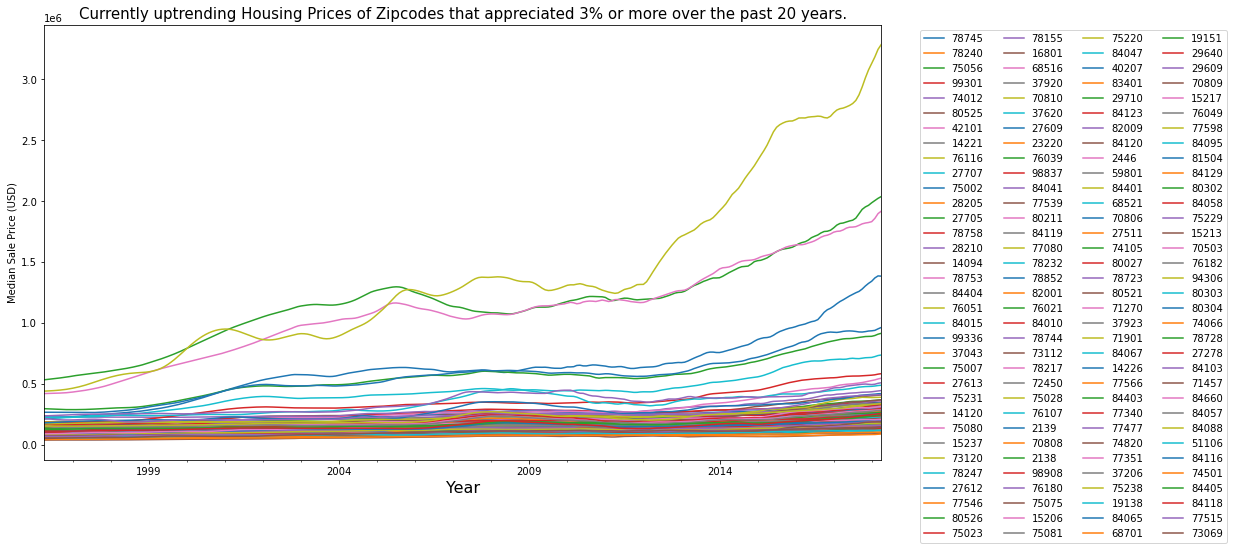

In [16]:
# Graph zipcode trend lines  
for zipcode in target_df_long.Zipcode.unique():
    temp_df = target_df_long[target_df_long.Zipcode == zipcode]
    temp_df['MedianValue'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left',ncol=4)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Median Sale Price (USD)")
plt.title('Currently uptrending Housing Prices of Zipcodes that appreciated 3% or more over the past 20 years.', fontsize = 15);
plt.show()

In [17]:
len(target_zip)

136

Looks like there are little more than 100 zipcodes that fit our criteria .Also interestingly We can see that most of the zipcodes have a current sales price of around $500000. To further assess the data we will determine the downside risk using coefficent of variance and precent return. 

In [18]:
# target_df =  target_df[target_df.columns.intersection(column_list)]
#Calculate Percent increase over past 20 years
target_df['Percent_increase']= ((target_df['2018-04']-target_df['1998-04']))*100/(target_df['1998-04'])
#Standard deviation over last 20 years
target_df['std(USD)']=target_df.loc[:,'1998-04':'2018-04'].std(skipna=True, axis=1)
#Mean over last 20 years
target_df['mean(USD)']=target_df.loc[:,'1998-04':'2018-04'].mean(skipna=True, axis=1)
#Calculate Coefficient of Variance
target_df['CV']=target_df['std(USD)']/target_df['mean(USD)']


In [19]:
target_df[['mean(USD)','Percent_increase','CV']].describe()

,mean(USD),Percent_increase,CV
count,1.360000e+02,136.000000,136.000000
mean,1.997370e+05,127.067051,0.200451
std,1.856471e+05,66.093542,0.056268
min,6.449502e+04,80.683311,0.119145
25%,1.284678e+05,91.881312,0.164506
50%,1.629434e+05,106.269270,0.187393
75%,1.933674e+05,127.702952,0.217671
max,1.453453e+06,471.918524,0.465926


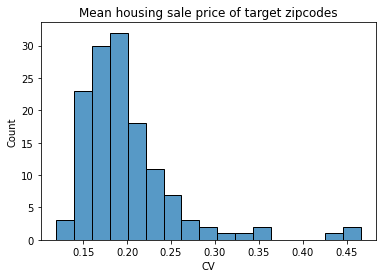

In [20]:
# Look at CV value distribution 
plt.title("Mean housing sale price of target zipcodes")
sns.histplot(x='CV',data=target_df)
plt.show()

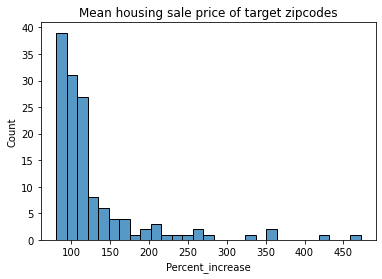

In [21]:
# Look at CV value distribution 
plt.title("Mean housing sale price of target zipcodes")
sns.histplot(x='Percent_increase',data=target_df)
plt.show()

Looks like CV values and percent returns are skewed suggesting there are some outliers associated with downside risk, lets get rid of these outliers to see if that changes anything. 

In [22]:
# get rid of outliers
target_df=target_df[(np.abs(stats.zscore(target_df['mean(USD)'])) < 3)]
target_df=target_df[(np.abs(stats.zscore(target_df['Percent_increase'])) < 3)]
target_df=target_df[(np.abs(stats.zscore(target_df['CV'])) < 3)]



In [23]:
target_df[['Zipcode','std(USD)','mean(USD)','Percent_increase','CV']].describe()


,std(USD),mean(USD),Percent_increase,CV
count,127.000000,127.000000,127.000000,127.000000
mean,33779.123340,172407.815206,112.552119,0.189142
std,21316.613880,79386.630888,32.310952,0.032932
min,10328.760438,64495.020747,80.683311,0.119145
25%,22032.775693,128460.165975,91.644878,0.162766
50%,30044.290088,161873.858921,104.294479,0.185036
75%,37589.299765,189983.609959,114.511658,0.211203
max,158688.950731,585053.112033,245.532831,0.282423


Lets look at the returns and  coeffience of variance to assess the risk due to volatility. 

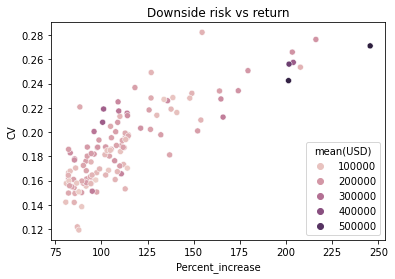

In [23]:
# Graph to see if volatility and percent increase over the years have any correlation 
plt.title("Downside risk vs return")
sns.scatterplot(y='CV',x='Percent_increase',data=target_df,hue='mean(USD)')
plt.show()

In [24]:
#Calculate the correlation coefficinet between percent increase and CV ratio
slope, intercept, r_value, p_value, std_err = stats.linregress(target_df['Percent_increase'],target_df['CV'])
r_value

0.8252729242969308

Seems There is a relatively high correlation between CV values and percent returns.

In [25]:
# target_df = target_df.loc[target_df['Percent_increase']< target_df['Percent_increase'].quantile(q=.950)]

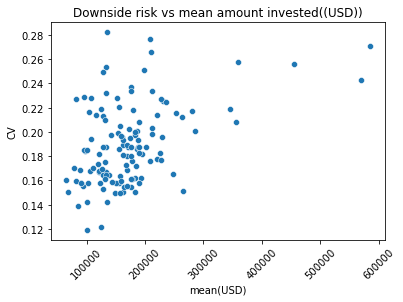

In [26]:
# Graph to see if volatility and mean sale price over the years have any correlation 

plt.title("Downside risk vs mean amount invested((USD))")
sns.scatterplot(y='CV',x='mean(USD)',data=target_df)
plt.xticks(rotation=45)
plt.show()

In [27]:
# target_df = target_df.loc[target_df['mean(USD)']< target_df['mean(USD)'].quantile(q=.950)]

In [28]:
#Calculate the correlation coefficient between  CV ratio and mean
slope, intercept, r_value, p_value, std_err = stats.linregress(target_df['mean(USD)'],target_df['CV'])
r_value

0.4509090063431819

 There is no visble pattern that suggests a relation between the investment amount and CV and the low correlation coefficeint further validates this observation. To this end we need to determine if the downside risk associated with the amount invested is constant or varying.  

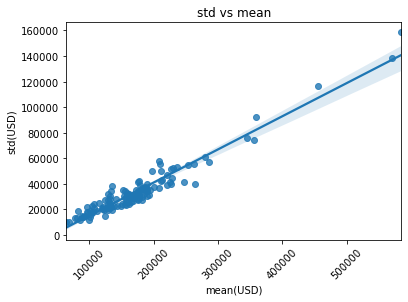

In [29]:
#Confirm CV is constant 
plt.title("std vs mean")
sns.regplot(target_df['mean(USD)'],target_df['std(USD)'])
plt.xticks(rotation=45)
plt.show()

In [30]:
#Confirm covariance is constant 
slope, intercept, r_value, p_value, std_err = stats.linregress(target_df['mean(USD)'],target_df['std(USD)'])
r_value

0.9656247784764693

Coefficient of variance is reasonably constant since the std and mean have a moderately high corelation. This suggests that the downside risk or the degree of volatility doesnt change with the amount invested (atleast for our zipcodes)

Based on the above observations first i would like to select zipcodes based on the volatility (CV values) . I decided to choose the 4th quintile as the  zipcodes in this group are within 2 standard deviations of the mean CV and still have a return of roughly 100-170%

In [31]:
# target_df = target_df.loc[target_df['Percent_increase']< target_df['Percent_increase'].quantile(q=.950)]

In [32]:
# Select 20 % of cv values (4th quintile).
target_df.sort_values(by='CV')
upperbound=target_df['CV'].quantile(q=.8)
lowerbound=target_df['CV'].quantile(q=.6)
target_df = target_df[(target_df['CV'] >= lowerbound) & (target_df['CV'] <= upperbound)]


In [33]:
len(target_df['Zipcode'].unique())

25

In [34]:
target_df = target_df.sort_values(by='Percent_increase',ascending=False).head(10)# choose the highest return zipcodes
# agg_df = target_df.sort_values(by='Percent_increase').tail(2)# choose the top2 highest percent increase.
# recession_proof_df = target_df.loc[target_df['Zipcode'].isin(Recession_proof_zip)]
# df=pd.concat([stable_df,agg_df,recession_proof_df])# join the two types of zipcdes into one dataframe
df=target_df.copy()

In [35]:
target_df['Percent_increase'].unique()

array([165.86475943, 153.83615085, 152.09090909, 140.83333333,
       132.14971209, 130.        , 126.53606411, 121.22641509,
       114.52205882, 114.50125733])

In [36]:
df.drop(['Percent_increase','std(USD)','mean(USD)','CV'], axis ='columns',inplace = True)

In [37]:
df.head()

,Zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
311,80525,157500.0,157900.0,158100.0,158100.0,158000.0,157800.0,157500.0,156900.0,156300.0,...,394200,395100,395800,396700,398000,400100,402700,405000,407200,408900
2333,70806,63000.0,63000.0,63000.0,63100.0,63100.0,63300.0,63500.0,63700.0,64000.0,...,187500,189100,189800,190000,191100,193100,194500,195300,195500,195200
1784,70808,85100.0,85600.0,86000.0,86600.0,87200.0,87900.0,88600.0,89200.0,89900.0,...,258500,261200,263400,266100,269300,272100,273400,274700,276200,277300
3660,73069,52200.0,52900.0,53500.0,54100.0,54700.0,55200.0,55800.0,56200.0,56700.0,...,140900,140900,141300,142000,142600,143400,144700,145400,145000,144500
1118,70810,84200.0,84600.0,84900.0,85300.0,85800.0,86300.0,86800.0,87400.0,88100.0,...,230200,232300,234600,236600,238200,239700,240700,241400,241800,241900


In [38]:
df_long = melt_data(df)

In [39]:
#Set month as the index
df_long.set_index('Month', inplace = True)

In [40]:
df_long.index=pd.to_datetime(df_long.index)

In [41]:
df_long.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2650 entries, 1996-04-01 to 2018-04-01
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Zipcode      2650 non-null   object 
 1   MedianValue  2650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 62.1+ KB


In [42]:
df_long.head()

,Zipcode,MedianValue
Month,,
1996-04-01,80525,157500.0
1996-04-01,70806,63000.0
1996-04-01,70808,85100.0
1996-04-01,73069,52200.0
1996-04-01,70810,84200.0


In [43]:
df_long['Zipcode'].unique()

array(['80525', '70806', '70808', '73069', '70810', '78744', '68516',
       '27609', '78753', '84118'], dtype=object)

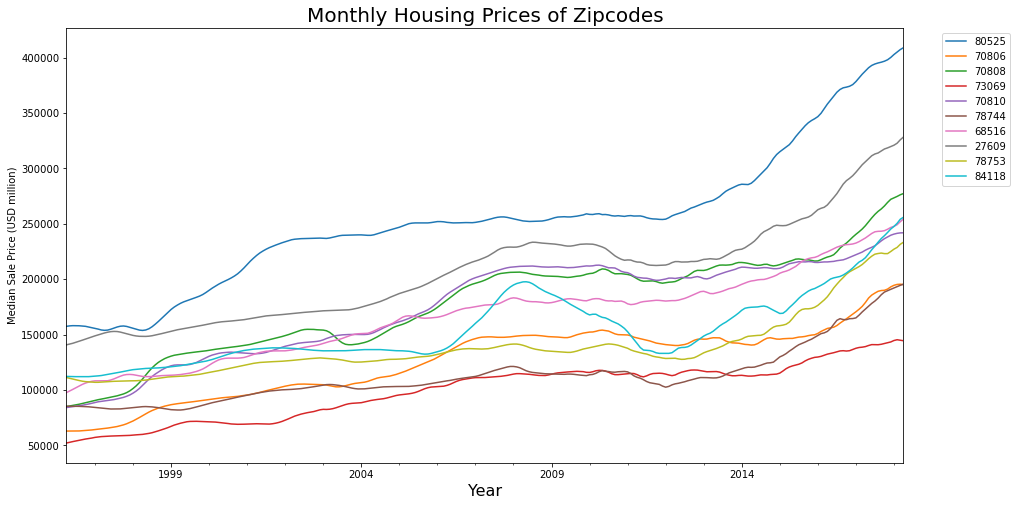

In [44]:
for zipcode in df_long.Zipcode.unique():
    temp_df = df_long[df_long.Zipcode == zipcode]
    temp_df['MedianValue'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Median Sale Price (USD million)")
plt.title('Monthly Housing Prices of Zipcodes', fontsize = 20);
plt.show()

Now that we have selected the zipcodes lets save each ina seperate dataframe

In [45]:
# create a seperate dataframe for each zipcode
df_zip=[]#  indexing each zipcode
for zipcode in df_long.Zipcode.unique():
    df_temp = df_long[df_long['Zipcode']==zipcode].asfreq('MS')
    df_zip.append(df_temp)

In [46]:
for df in df_zip:
    display(df.head())

,Zipcode,MedianValue
Month,,
1996-04-01,80525,157500.0
1996-05-01,80525,157900.0
1996-06-01,80525,158100.0
1996-07-01,80525,158100.0
1996-08-01,80525,158000.0


,Zipcode,MedianValue
Month,,
1996-04-01,70806,63000.0
1996-05-01,70806,63000.0
1996-06-01,70806,63000.0
1996-07-01,70806,63100.0
1996-08-01,70806,63100.0


,Zipcode,MedianValue
Month,,
1996-04-01,70808,85100.0
1996-05-01,70808,85600.0
1996-06-01,70808,86000.0
1996-07-01,70808,86600.0
1996-08-01,70808,87200.0


,Zipcode,MedianValue
Month,,
1996-04-01,73069,52200.0
1996-05-01,73069,52900.0
1996-06-01,73069,53500.0
1996-07-01,73069,54100.0
1996-08-01,73069,54700.0


,Zipcode,MedianValue
Month,,
1996-04-01,70810,84200.0
1996-05-01,70810,84600.0
1996-06-01,70810,84900.0
1996-07-01,70810,85300.0
1996-08-01,70810,85800.0


,Zipcode,MedianValue
Month,,
1996-04-01,78744,85400.0
1996-05-01,78744,85400.0
1996-06-01,78744,85300.0
1996-07-01,78744,85300.0
1996-08-01,78744,85300.0


,Zipcode,MedianValue
Month,,
1996-04-01,68516,97700.0
1996-05-01,68516,99100.0
1996-06-01,68516,100600.0
1996-07-01,68516,102100.0
1996-08-01,68516,103700.0


,Zipcode,MedianValue
Month,,
1996-04-01,27609,140800.0
1996-05-01,27609,141500.0
1996-06-01,27609,142200.0
1996-07-01,27609,143100.0
1996-08-01,27609,144000.0


,Zipcode,MedianValue
Month,,
1996-04-01,78753,111300.0
1996-05-01,78753,110600.0
1996-06-01,78753,109900.0
1996-07-01,78753,109200.0
1996-08-01,78753,108600.0


,Zipcode,MedianValue
Month,,
1996-04-01,84118,112300.0
1996-05-01,84118,112200.0
1996-06-01,84118,112200.0
1996-07-01,84118,112100.0
1996-08-01,84118,112100.0


### Detrending

From the trendline we know the median sales price for our 5 zipcodes are on a uptrend but we will just confirm First we will check for trends using rolling mean and stand deviation.

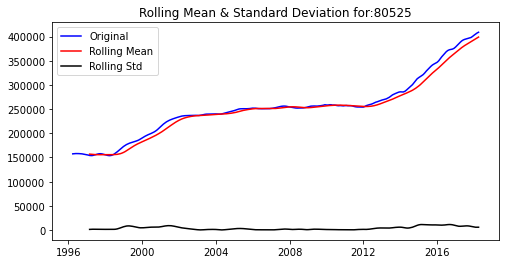

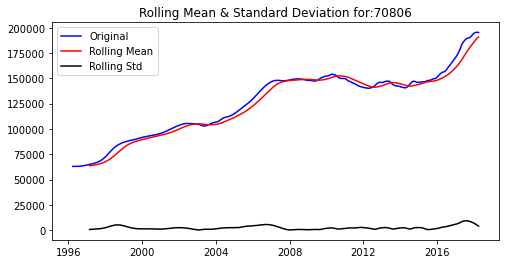

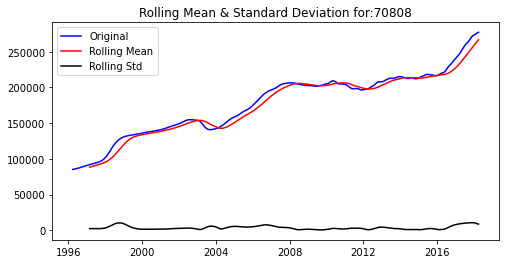

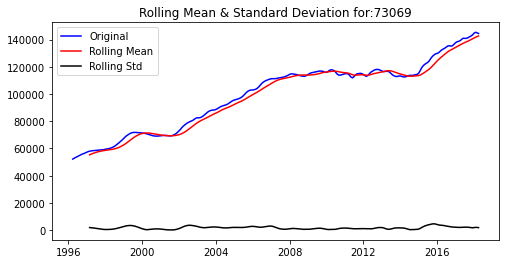

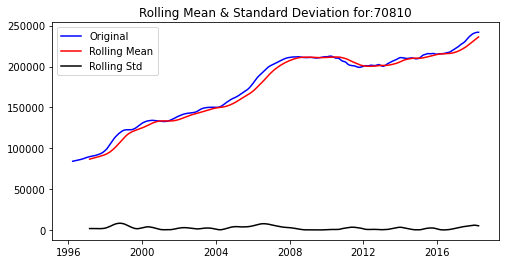

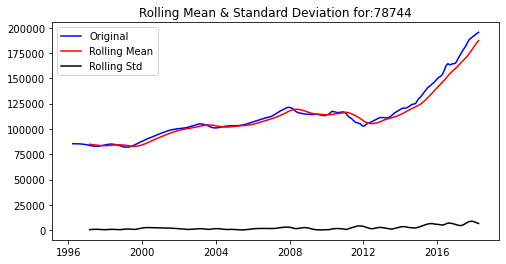

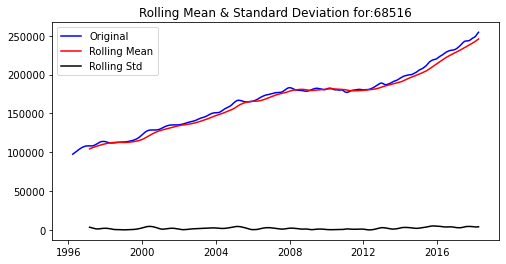

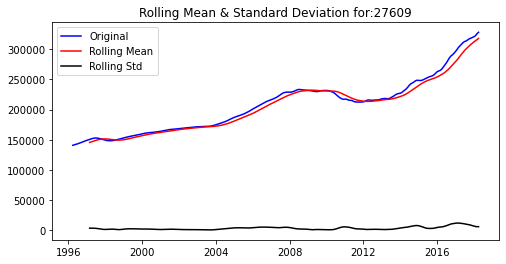

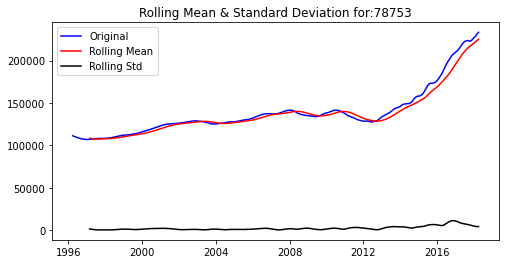

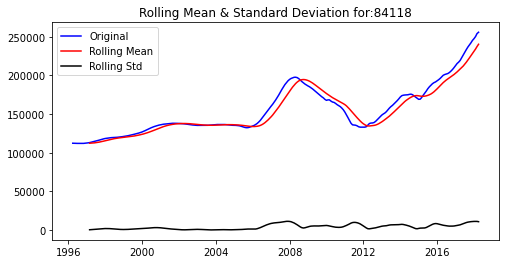

In [47]:
for i in range(len(df_zip)):
    roll_mean =  df_zip[i].drop(columns='Zipcode').rolling(window=12).mean()
    roll_std = df_zip[i].drop(columns='Zipcode').rolling(window=12).std()
    fig = plt.figure(figsize=(8,4))
    plt.plot(df_zip[i].drop(columns='Zipcode'), color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for:{df_zip[i].Zipcode[0]}')
    plt.show(block=False)

Rolling Standard deviation is more or less constant for all zipcodes suggesting that variance in sales price for each zipcode over the last 2 decades is not a funtion of time.However as a consquence of selectring uptrending zip the sales price has a trend.

Lets use log transform to detrend 

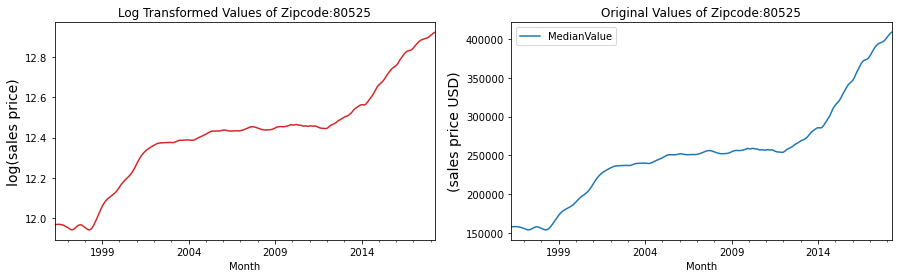

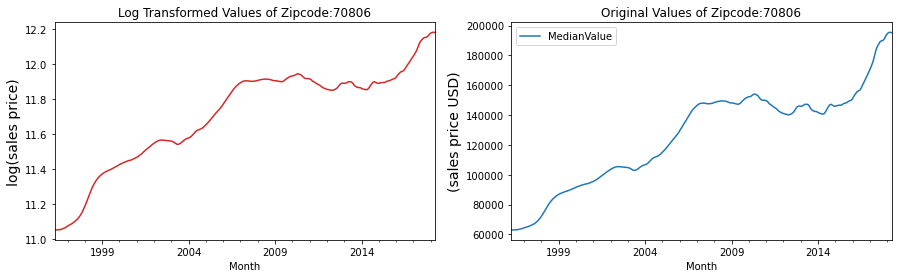

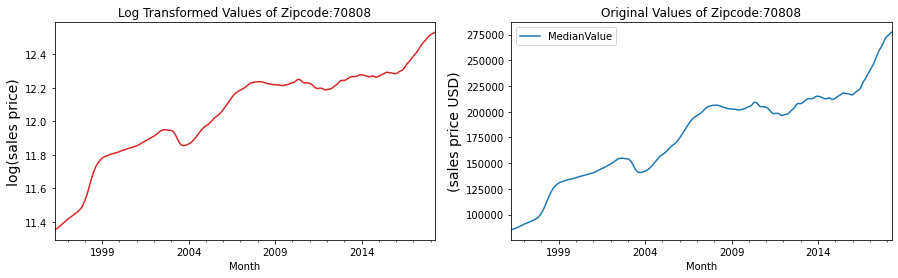

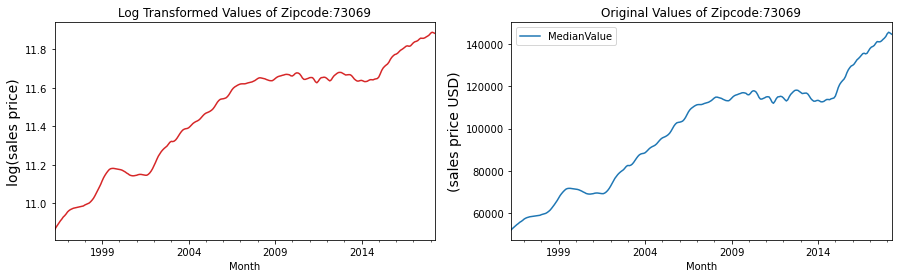

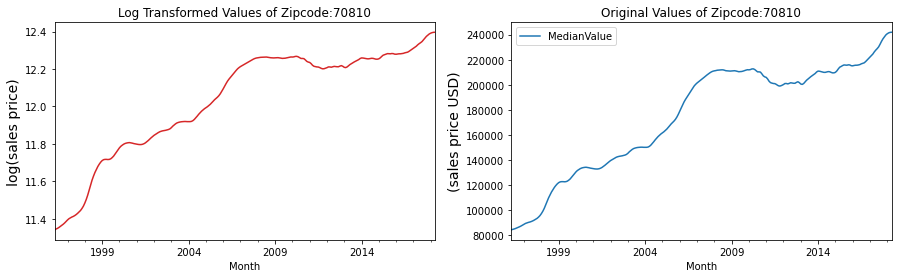

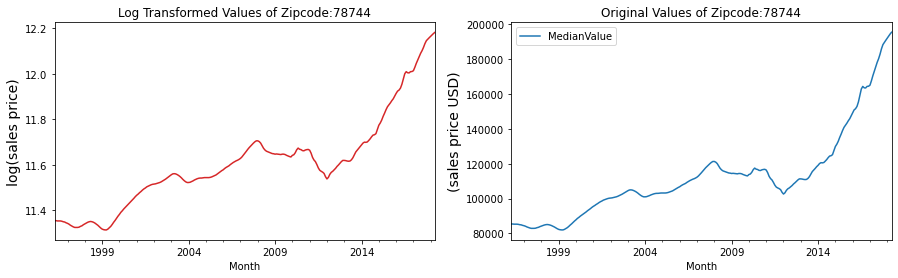

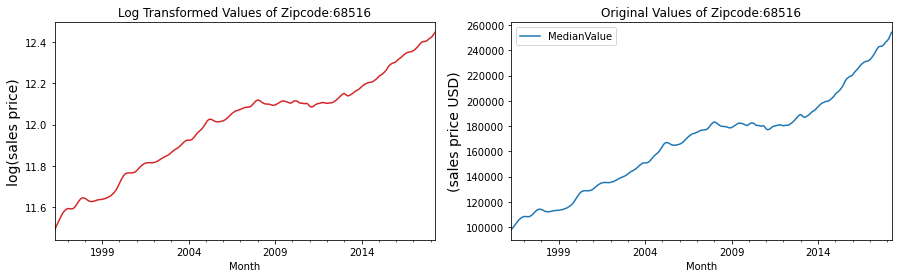

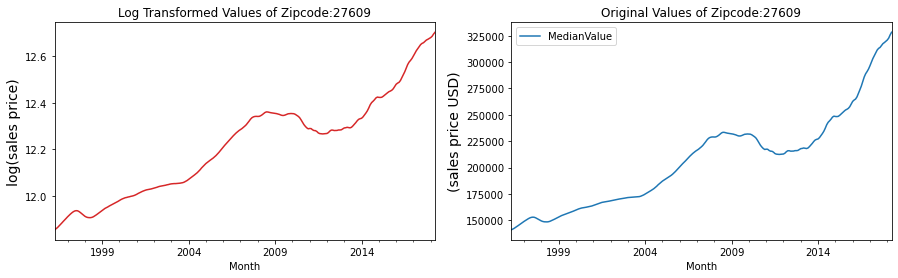

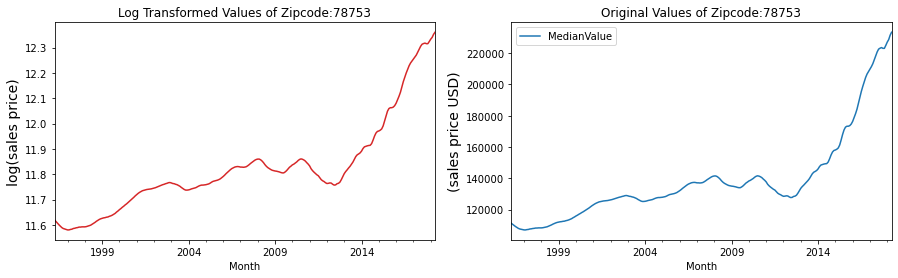

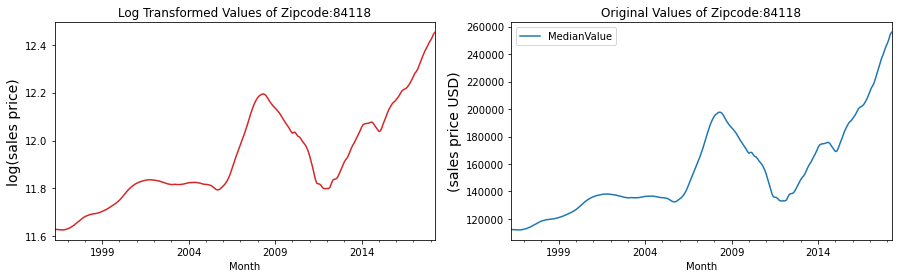

In [48]:
df_log=[]
for i in range(len(df_zip)):    
    temp_df = df_zip[i]["MedianValue"].apply(lambda x : np.log(x))
#     temp_df = df_zip[i]["MedianValue"].apply(lambda x : np.power(x,6/10))
    df_log.append(temp_df)
    
    plt.figure()
    plt.xlabel('Year', fontsize=14)
    ax1 = plt.subplot(121)
    temp_df.plot(figsize=(15,4) ,color="tab:red", title=f"Log Transformed Values of Zipcode:{df_zip[i].Zipcode[0]}", ax=ax1);
    plt.ylabel('log(sales price)', fontsize=14)
    ax2 = plt.subplot(122)
    df_zip[i].plot( title=f"Original Values of Zipcode:{df_zip[i].Zipcode[0]}", ax=ax2);
    plt.ylabel('(sales price USD)', fontsize=14)

Given how the target zipcode we filtered, our zipcodes dont exhibit very aggressive appreciation, most of the have about doubled in value over the last 2 decades so log transforming the time series doesnt exhibit anything different. We will check for stationarity on this log trasnformed data.

In [49]:
# Run a ADfuller test to check for stationarity on log transformed zipcode sales data
roll_list=[]# time series that pass stationarity
for i in range(len(df_log)):
    print(f'ADFuller test results for : {df_zip[i].Zipcode[0]}')
    adfuller_result = adfuller( df_log[i].iloc[:])
    adfuller_output = pd.Series(adfuller_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in adfuller_result[4].items():
        adfuller_output['Critical Value (%s)'%key] = value
    print(adfuller_output)
    if adfuller_result[1]>0.05:
        print('Fail to reject H0. Data is not stationary.\n')
    else:
        roll_list.append(i)
        print('Reject H0. Data is stationary.\n')
print(f'Number of stationary time series :{len(roll_list)}')

ADFuller test results for : 80525
Test Statistic                  -1.289676
p-value                          0.633882
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
Fail to reject H0. Data is not stationary.

ADFuller test results for : 70806
Test Statistic                  -2.044166
p-value                          0.267550
#Lags Used                      11.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64
Fail to reject H0. Data is not stationary.

ADFuller test results for : 70808
Test Statistic                  -2.270790
p-value                          0.181562
#Lags Used                      11.000000
Number of Observations Used    253.000000
Critical Value (1%)     

Only 1 of the time series is stationary lets try first order differencing since each months appreciation is dependent on the previous month.

In [50]:
# first order differencing 
data_diff=[]
for i in range(len (df_log)):
    temp_df =df_log[i].diff()
    temp_df.dropna(inplace=True)
    data_diff.append(temp_df)

In [51]:
# Run a ADfuller test to check for stationarity on 1-differenced zipcode sales data
diff_list=[]
for i in range(len(data_diff)):
    print(f'ADFuller test results for : {df_zip[i].Zipcode[0]}')
    adfuller_result = adfuller( data_diff[i].iloc[:])
    adfuller_output = pd.Series(adfuller_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in adfuller_result[4].items():
        adfuller_output['Critical Value (%s)'%key] = value
    print(adfuller_output)
    if adfuller_result[1]>0.05:
        print('Fail to reject H0. Data is not stationary.\n')
        
    else:
        diff_list.append(i)
        print('Reject H0. Data is stationary.\n')
print(f'Number of stationary time series after first order differencing:{len(diff_list)}')

ADFuller test results for : 80525
Test Statistic                  -2.245122
p-value                          0.190278
#Lags Used                      12.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
Fail to reject H0. Data is not stationary.

ADFuller test results for : 70806
Test Statistic                  -3.336278
p-value                          0.013333
#Lags Used                      10.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64
Reject H0. Data is stationary.

ADFuller test results for : 70808
Test Statistic                  -3.131505
p-value                          0.024308
#Lags Used                      11.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.4

5 of the 10 time series are now stationary , lets try second order diffferencing , perhaps some of the time series are experiencing  a trend of higher order.

In [52]:
# Run a ADfuller test to check for stationarity on log transformed zipcode sales data
diff_list2=[]
for i in range(len(data_diff)):
    print(f'ADFuller test results for : {df_zip[i].Zipcode[0]}')
    adfuller_result = adfuller( data_diff[i].diff().dropna().iloc[:])
    adfuller_output = pd.Series(adfuller_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in adfuller_result[4].items():
        adfuller_output['Critical Value (%s)'%key] = value
    print(adfuller_output)
    if adfuller_result[1]>0.05:
        print('Fail to reject H0. Data is not stationary.\n')
        
    else:
        if i not in diff_list: 
            diff_list2.append(i)
            print('Reject H0. Data is stationary.\n')
print(f'Number of stationary time series after first order differencing:{len(diff_list+diff_list2)}')
       

ADFuller test results for : 80525
Test Statistic                -6.321992e+00
p-value                        3.050162e-08
#Lags Used                     1.100000e+01
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Reject H0. Data is stationary.

ADFuller test results for : 70806
Test Statistic                  -5.559681
p-value                          0.000002
#Lags Used                       9.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64
ADFuller test results for : 70808
Test Statistic                -6.217861e+00
p-value                        5.311446e-08
#Lags Used                     1.100000e+01
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value

2nd order differncing resulted in all time series being stationary , lets look at the decompostion of time series that did not result in stationarity after first order difference to look at seasonality.

In [53]:
# diff_list

In [54]:
# diff_list2

Test Statistic                  -1.809111
p-value                          0.375948
#Lags Used                      16.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64
Residual is not stationary.

Test Statistic                  -3.470625
p-value                          0.008774
#Lags Used                      16.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64
Residual is stationary.

Test Statistic                  -1.749478
p-value                          0.405817
#Lags Used                      16.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64
Residual is not sta

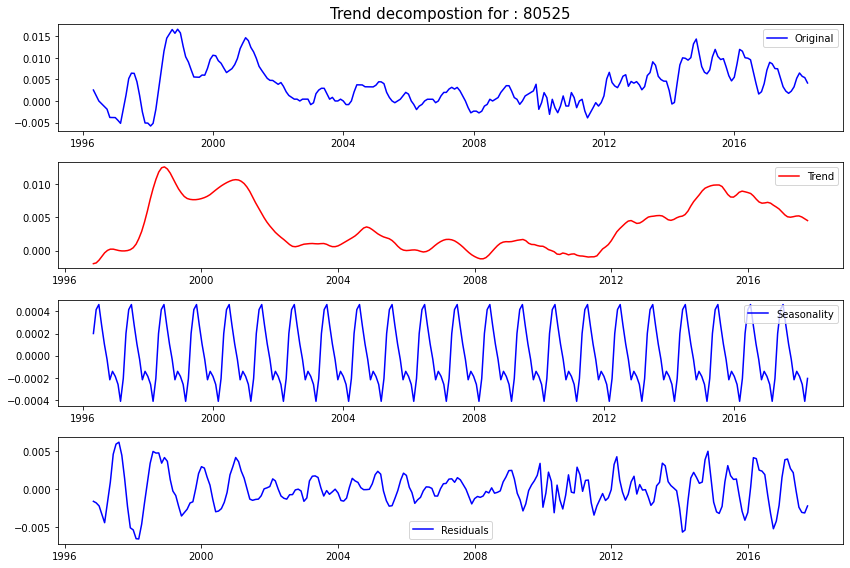

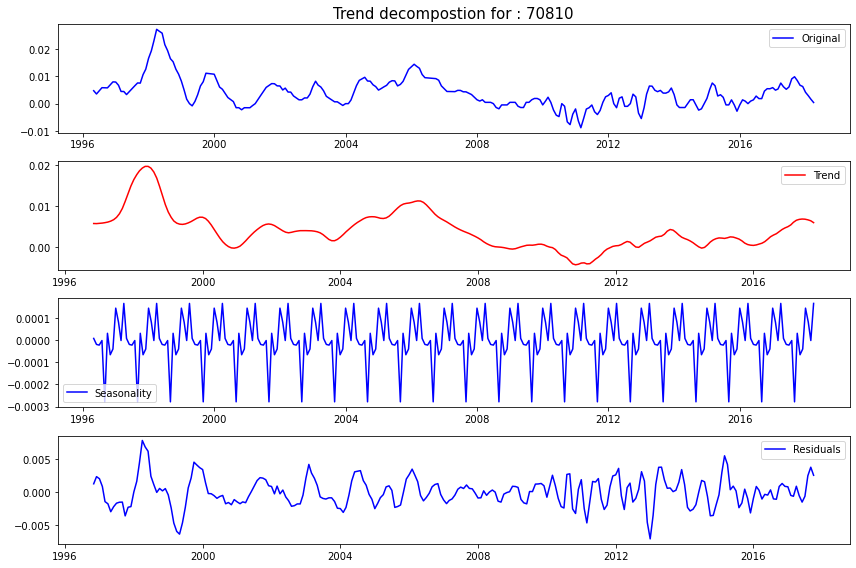

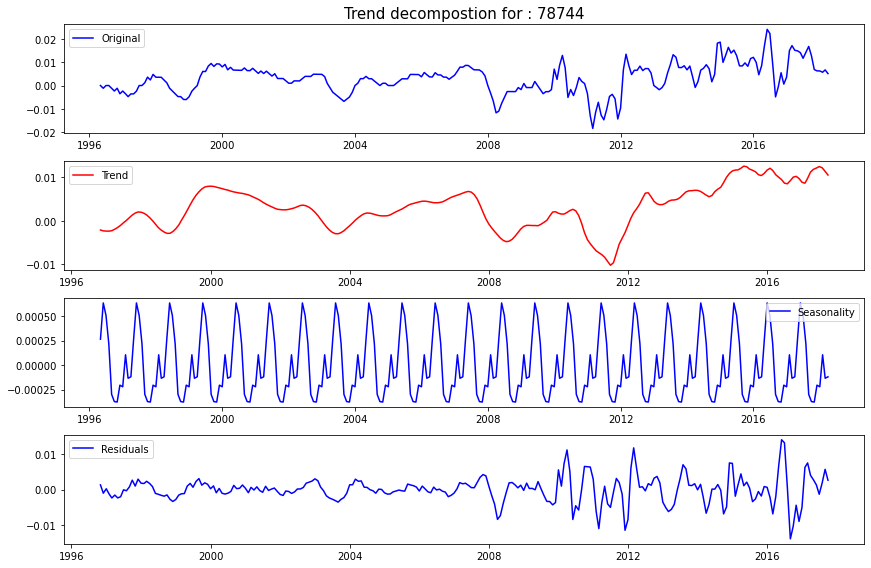

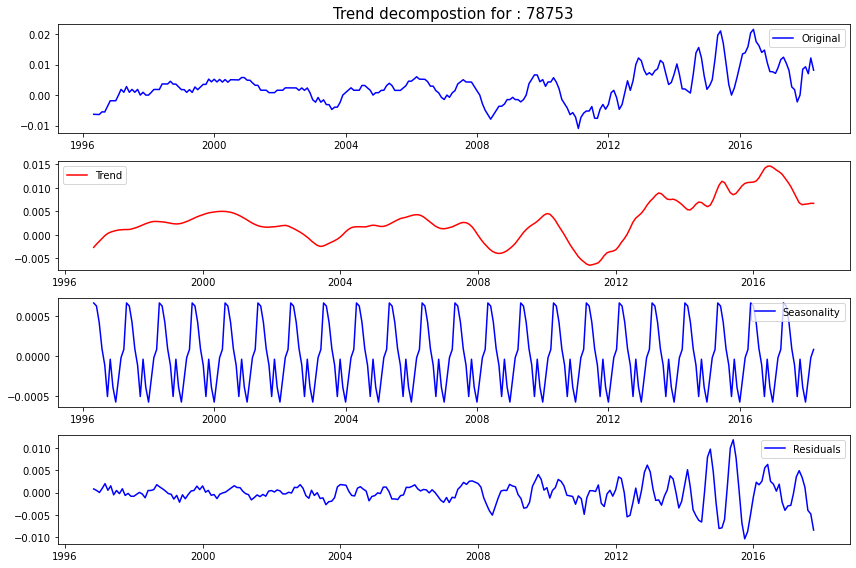

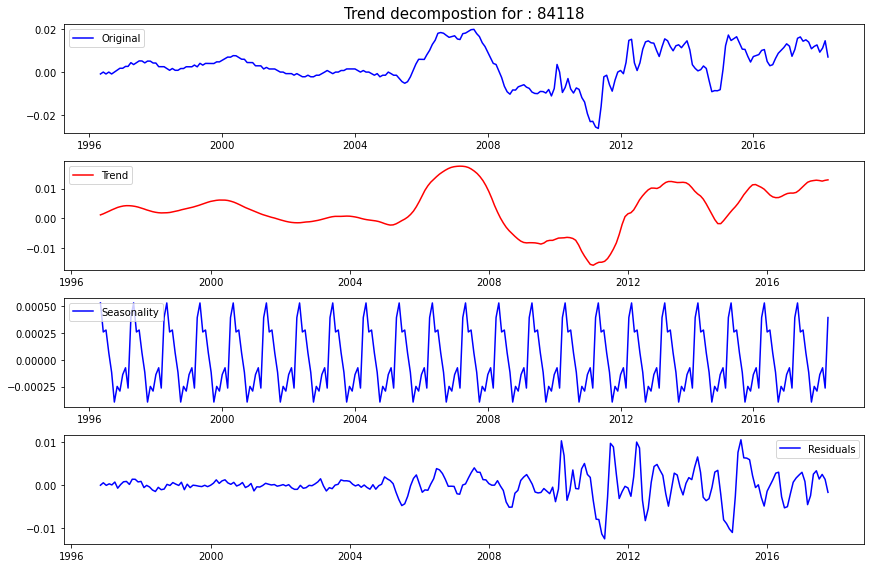

In [55]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose

for i in range(len(data_diff)):
    if i not in  diff_list:
        decomposition = seasonal_decompose((data_diff[i]),model='additive')
        # Gather the trend, seasonality, and residuals 
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
        stationarity_test=adfuller(trend.dropna())
        adfuller_output = pd.Series(stationarity_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
        for key,value in stationarity_test[4].items():
            adfuller_output['Critical Value (%s)'%key] = value
        print(adfuller_output)
        if stationarity_test[1]>0.01:
            print('Residual is not stationary.\n')

        else:
            print('Residual is stationary.\n')

        # Plot gathered statistics
        plt.figure(figsize=(12,8))
        plt.subplot(411)
        plt.title(f'Trend decompostion for : {df_zip[i].Zipcode[i]}',size=15)
        plt.plot(data_diff[i], label='Original', color='blue')
        plt.legend(loc='best')
        plt.subplot(412)
        plt.plot(trend, label='Trend', color='red')
        plt.legend(loc='best')
        plt.subplot(413)
        plt.plot(seasonal,label='Seasonality', color='blue')
        plt.legend(loc='best')
        plt.subplot(414)
        plt.plot(residual, label='Residuals', color='blue')
        plt.legend(loc='best')
        plt.tight_layout()   


Looks like the trend on some of the zipcodes might be of second order since its not stationary after 1st order differencing . 

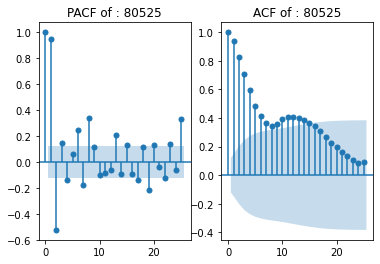

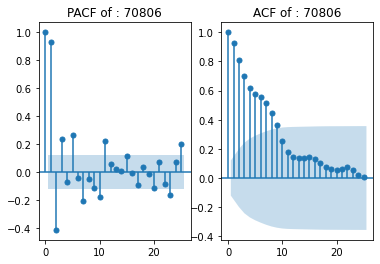

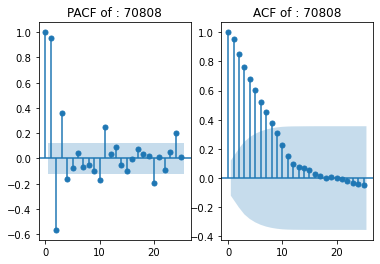

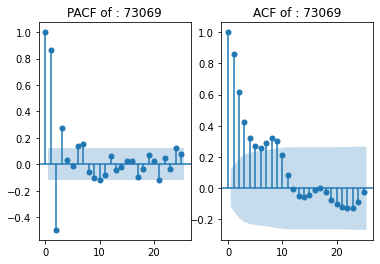

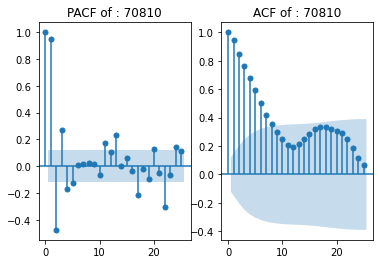

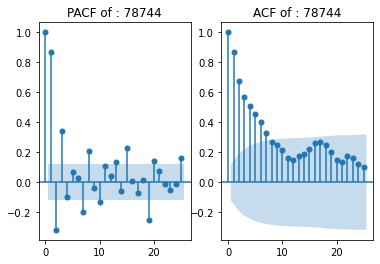

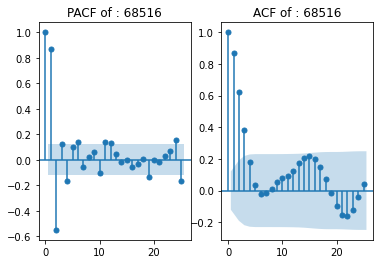

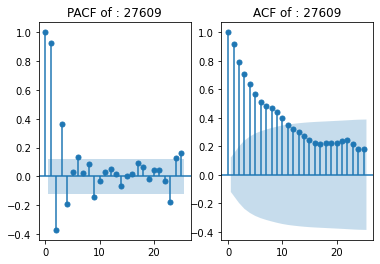

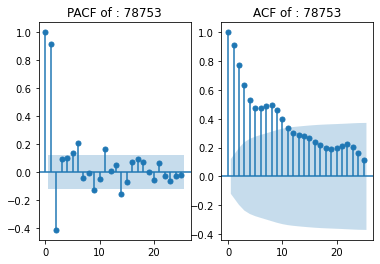

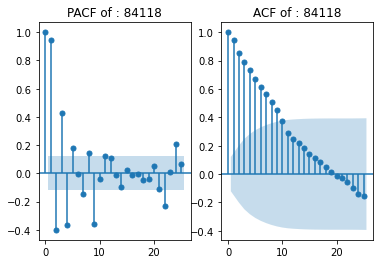

In [56]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf


for i in range(0,10):
#     if i in diff_list:
        plt.figure()
        ax1 = plt.subplot(121)
        plot_pacf( data_diff[i],ax=ax1,title=(f'PACF of : {df_zip[i].Zipcode[i]}'));
        ax2 = plt.subplot(122)
        plot_acf( data_diff[i],ax=ax2,title=(f'ACF of : {df_zip[i].Zipcode[i]}'))
   

   
    

For zipcodes that were not stationary after first order differencing , The ACF is tailing off to zero with the number of non-zero autocorrelations being 10 or less, we can use an MA order of upto 10 .For PACF besides lag of 1 all zipcodes have  a few lags >1 that are statistically significant. Using  auto arima might be the best option here Since there exists a possible range  of MA and AR order. Furthermore we can see in the decompostion there exists a mild seasonality so theres a good chance that pdqs is not 0 for the seasonal component. 

### Modelling

In [57]:
import pmdarima as pm

In [58]:
ARIMA_results=[]
for i in range(len (df_log)):
    results =pm.auto_arima(df_log[i],information_criterion='aic',m=12,
                        start_p=1,start_q=1, max_p=10, max_q=10,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
#     temp_df.dropna(inplace=True)
    ARIMA_results.append(results)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-2717.192, Time=2.91 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-2083.633, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-2648.779, Time=1.61 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-2400.874, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1960.517, Time=0.16 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-2714.677, Time=2.17 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-2607.494, Time=1.46 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=-2731.251, Time=7.64 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=-2643.246, Time=3.48 sec
 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=6.85 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=-2724.742, Time=3.79 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=-2402.356, Time=4.17 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-2672.297, Time=4.36 sec
 ARIMA(2,1,1)(2,0,1)[12] intercept   : AIC=-2651.593, Time=3.55 sec
 ARIMA(1,1,

 ARIMA(0,2,1)(1,0,1)[12]             : AIC=-2663.352, Time=0.25 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=-2658.982, Time=1.95 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=-2661.992, Time=0.26 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=-2660.106, Time=2.51 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=-2624.175, Time=0.38 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=-2665.672, Time=0.61 sec
 ARIMA(0,2,2)(0,0,1)[12]             : AIC=-2668.992, Time=0.51 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=-2657.793, Time=0.37 sec
 ARIMA(1,2,2)(0,0,1)[12]             : AIC=-2667.453, Time=0.76 sec
 ARIMA(0,2,1)(0,0,1)[12] intercept   : AIC=-2667.839, Time=1.39 sec

Best model:  ARIMA(0,2,1)(0,0,1)[12]          
Total fit time: 10.414 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=-2294.701, Time=0.68 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-2254.756, Time=0.05 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-2269.519, Time=0.3

 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=-2463.834, Time=5.92 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=-1789.480, Time=3.21 sec
 ARIMA(0,1,2)(0,0,2)[12] intercept   : AIC=-2304.124, Time=4.87 sec
 ARIMA(2,1,0)(0,0,2)[12] intercept   : AIC=-2443.466, Time=5.39 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-2424.957, Time=6.66 sec
 ARIMA(1,1,1)(0,0,2)[12]             : AIC=-2447.724, Time=1.71 sec

Best model:  ARIMA(1,1,1)(0,0,2)[12] intercept
Total fit time: 73.479 seconds


In [59]:
for i in range(len(data_diff)) :
    if i in diff_list:
        print(ARIMA_results[i].order)
        print(ARIMA_results[i].seasonal_order)

(1, 2, 2)
(0, 0, 1, 12)
(2, 2, 0)
(0, 0, 1, 12)
(2, 2, 1)
(1, 0, 1, 12)
(2, 1, 1)
(1, 0, 1, 12)
(1, 1, 1)
(0, 0, 2, 12)


In [106]:
df_result=pd.DataFrame()
df_result['Zipcode']=target_df['Zipcode'].values
df_result.set_index('Zipcode',inplace=True)

Results for zipcode : 80525
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9291      0.020     45.954      0.000       0.889       0.969
ma.L1          0.4603      0.043     10.743      0.000       0.376       0.544
ar.S.L12       0.4916      0.259      1.898      0.058      -0.016       0.999
ar.S.L24      -0.2045      0.061     -3.372      0.001      -0.323      -0.086
ma.S.L12      -0.5463      0.275     -1.989      0.047      -1.084      -0.008
sigma2      1.831e-06   1.23e-07     14.847      0.000    1.59e-06    2.07e-06


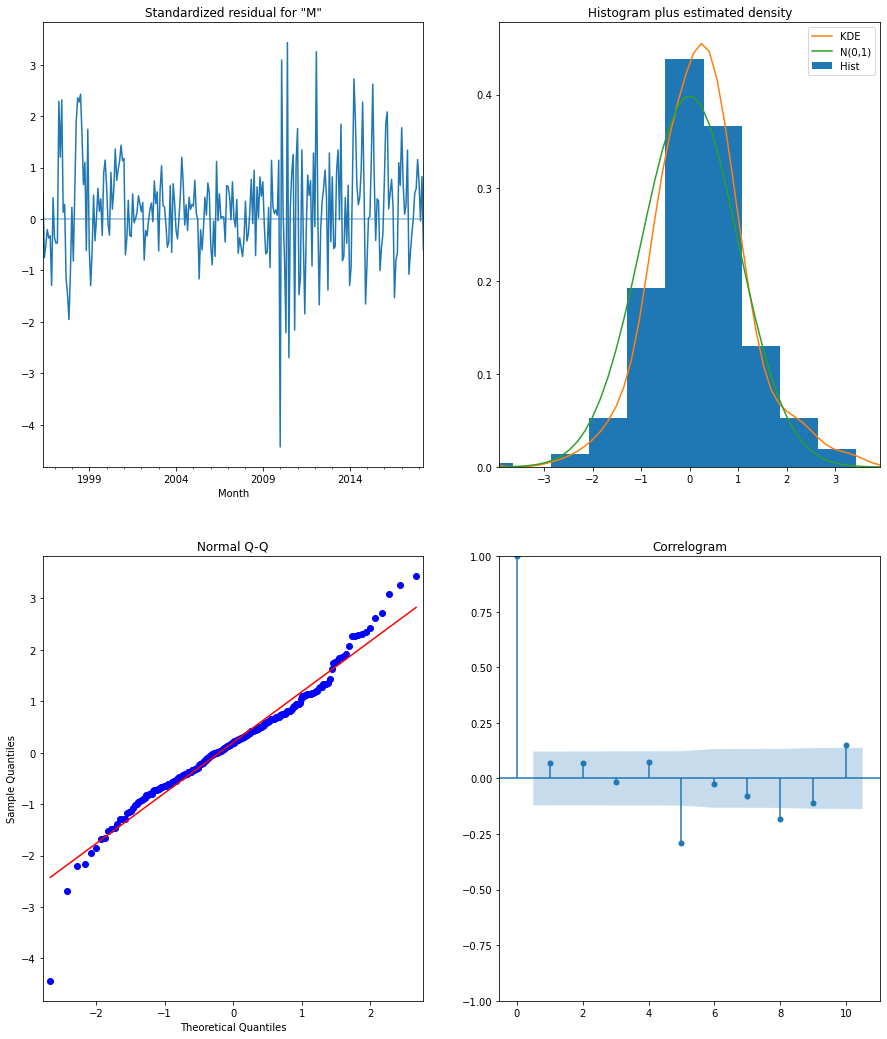

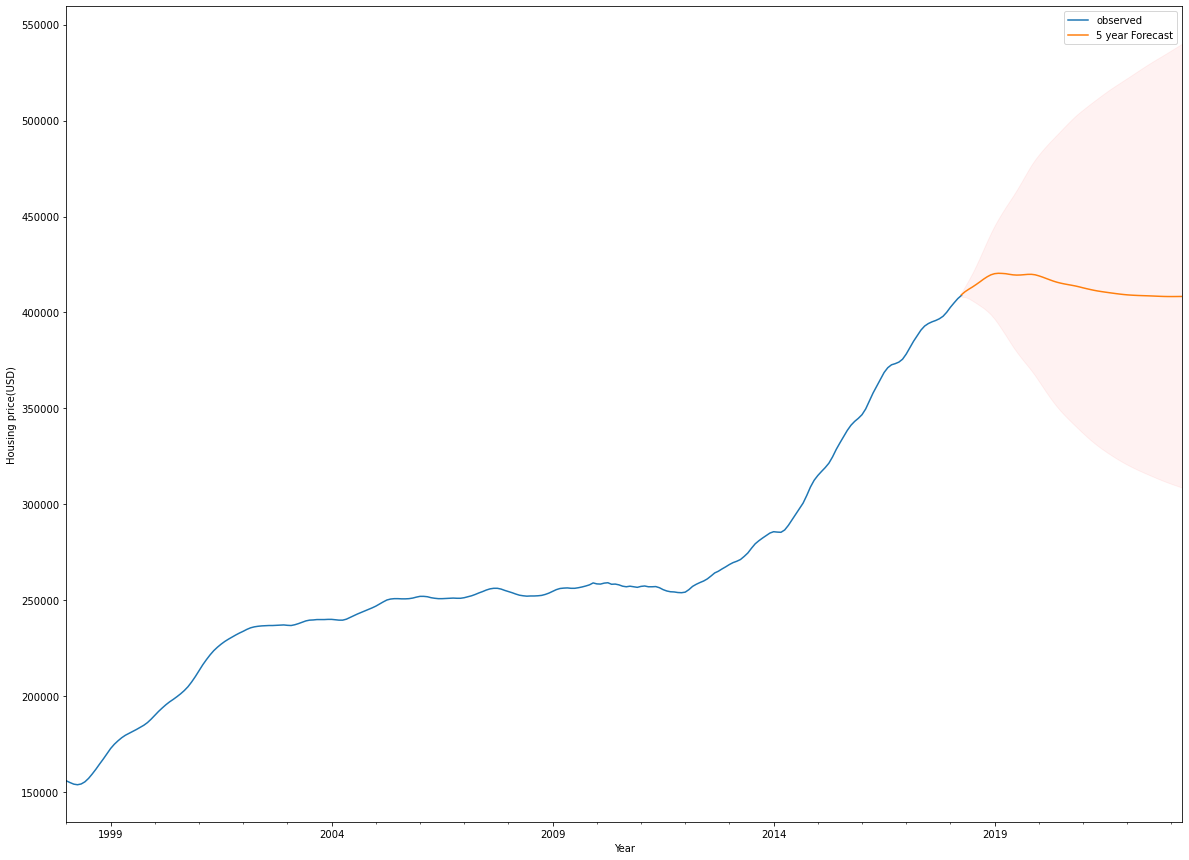

Expected 5 year return (USD):[408338.16194429]
Expected 5 year return (percent):[-0.13740231]
Results for zipcode : 70806
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5817      0.462      1.258      0.208      -0.324       1.488
ma.L1         -0.1022      0.459     -0.223      0.824      -1.002       0.797
ma.L2         -0.3733      0.221     -1.692      0.091      -0.806       0.059
ma.S.L12      -0.2911      0.053     -5.452      0.000      -0.396      -0.186
sigma2      3.893e-06   2.61e-07     14.911      0.000    3.38e-06    4.41e-06


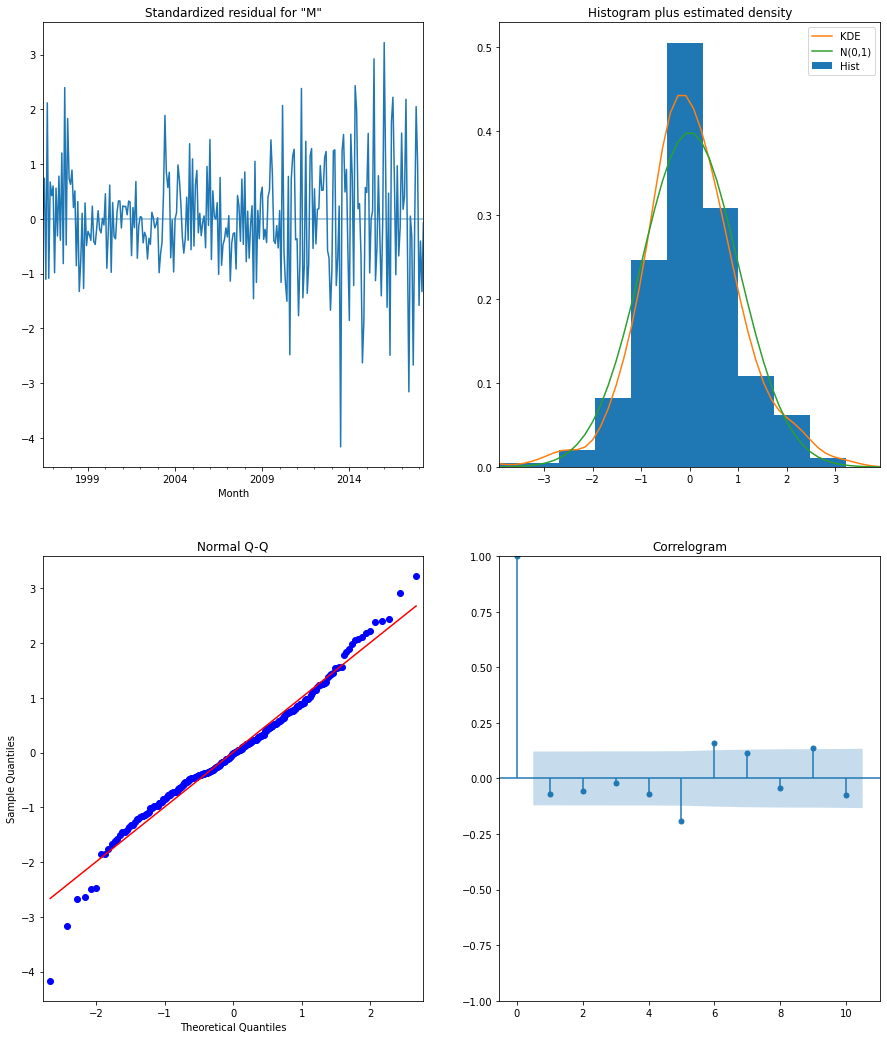

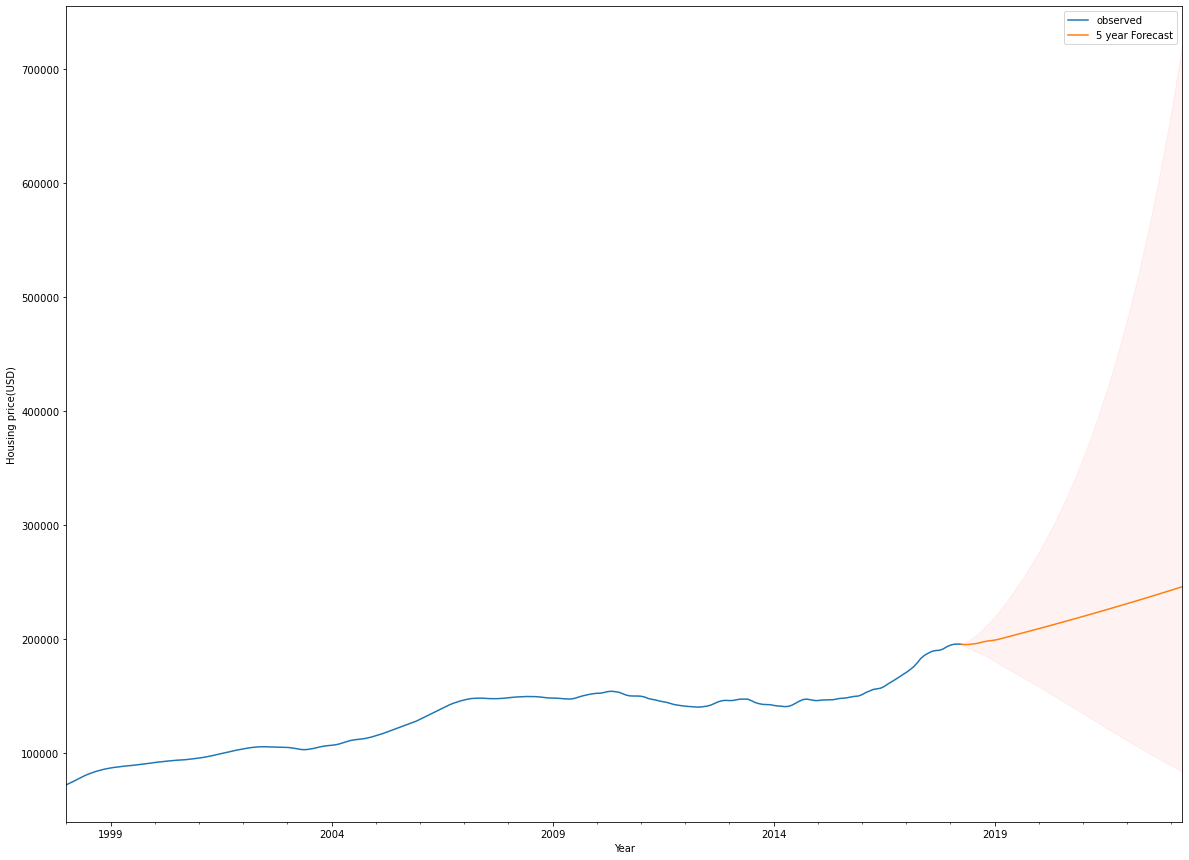

Expected 5 year return (USD):[245817.70990474]
Expected 5 year return (percent):[25.93120384]
Results for zipcode : 70808
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6601      0.050     13.136      0.000       0.562       0.759
ar.L2         -0.3460      0.055     -6.322      0.000      -0.453      -0.239
ma.S.L12      -0.3631      0.062     -5.818      0.000      -0.485      -0.241
sigma2      2.871e-06    2.6e-07     11.060      0.000    2.36e-06    3.38e-06


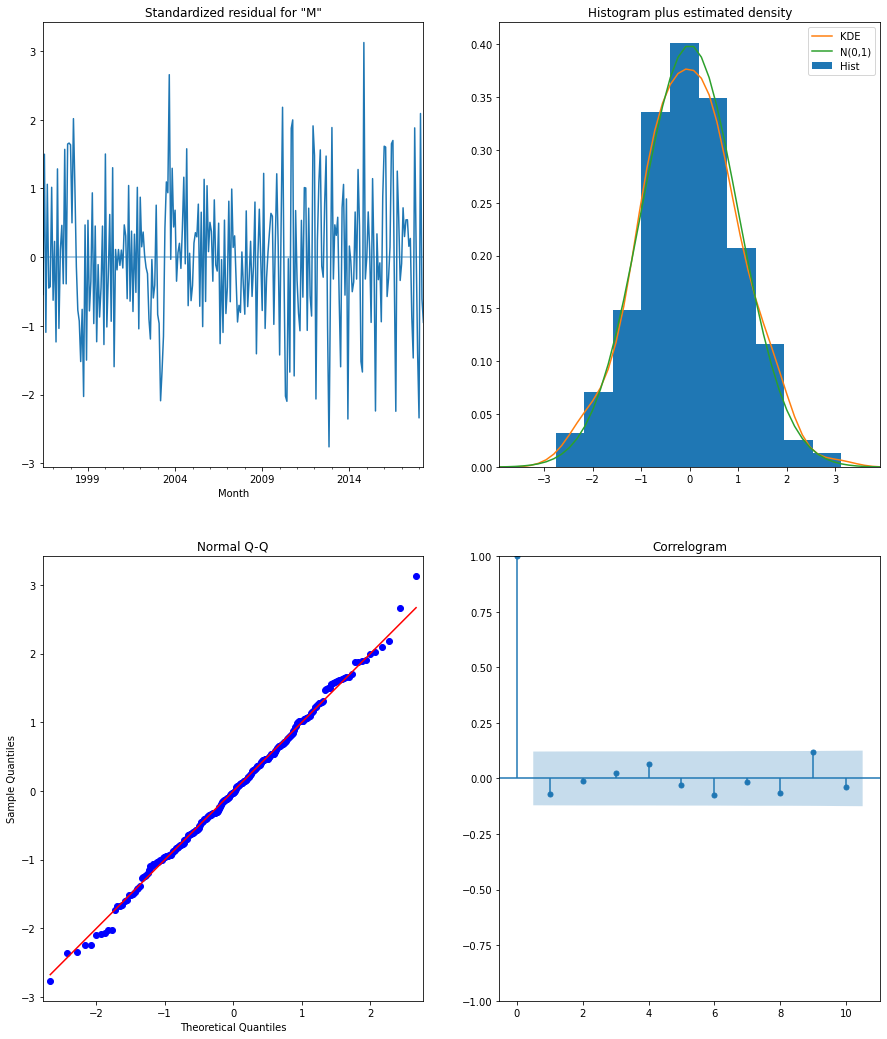

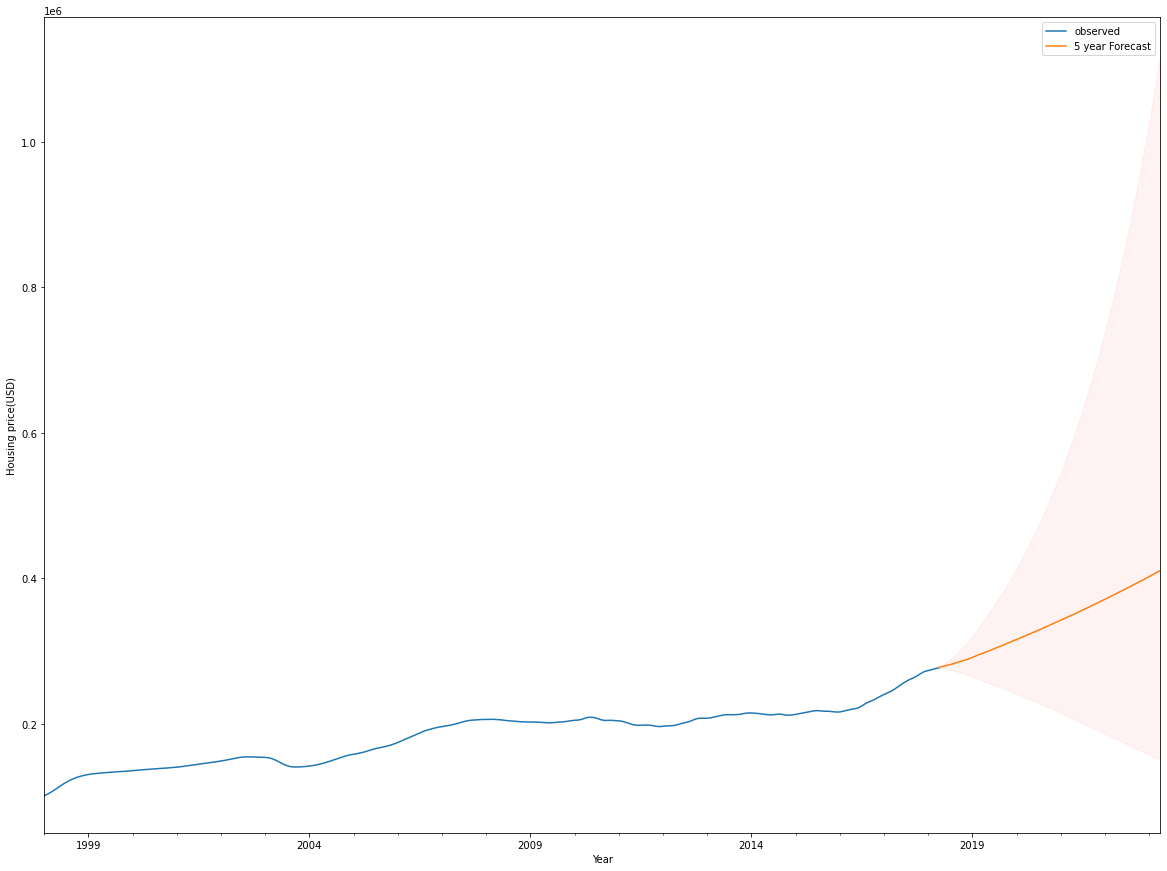

Expected 5 year return (USD):[410752.25310471]
Expected 5 year return (percent):[48.12558713]
Results for zipcode : 73069
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0969      0.101     10.913      0.000       0.900       1.294
ar.L2         -0.4295      0.055     -7.781      0.000      -0.538      -0.321
ma.L1         -0.7785      0.102     -7.595      0.000      -0.979      -0.578
ar.S.L12       0.3079      0.146      2.109      0.035       0.022       0.594
ma.S.L12      -0.6468      0.130     -4.965      0.000      -0.902      -0.391
sigma2      5.391e-06   4.62e-07     11.674      0.000    4.49e-06     6.3e-06


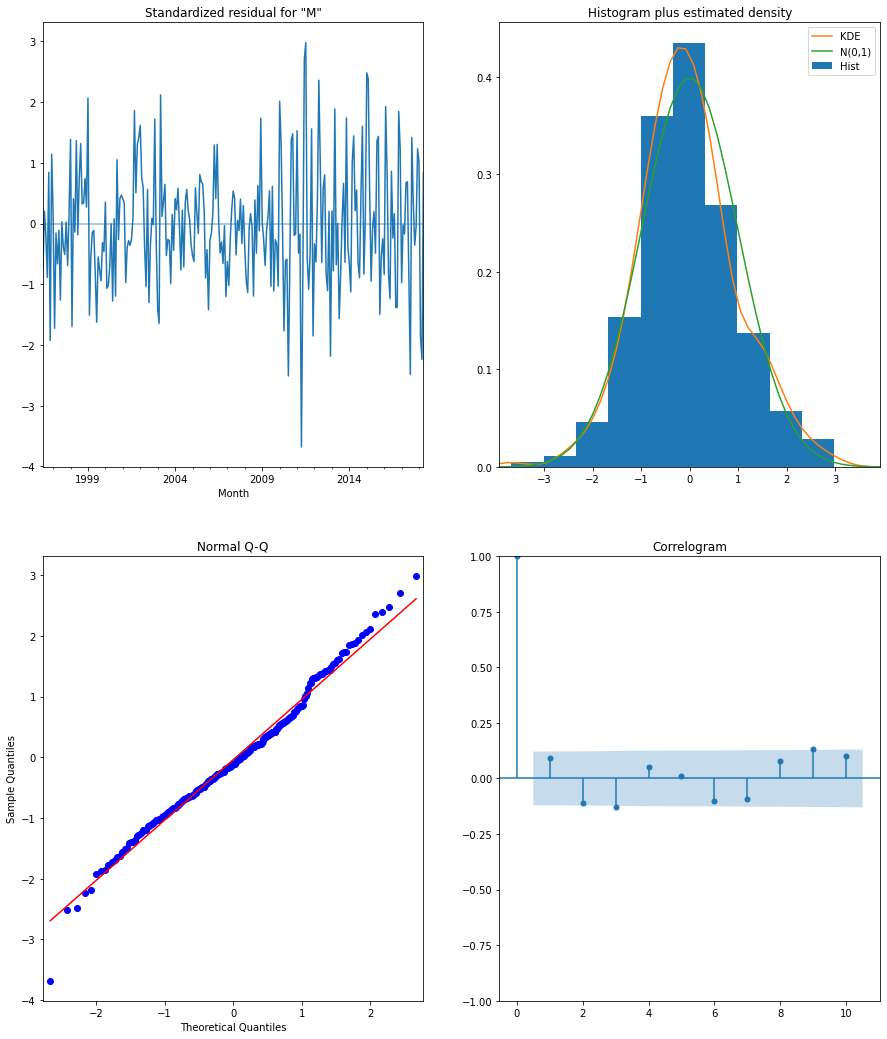

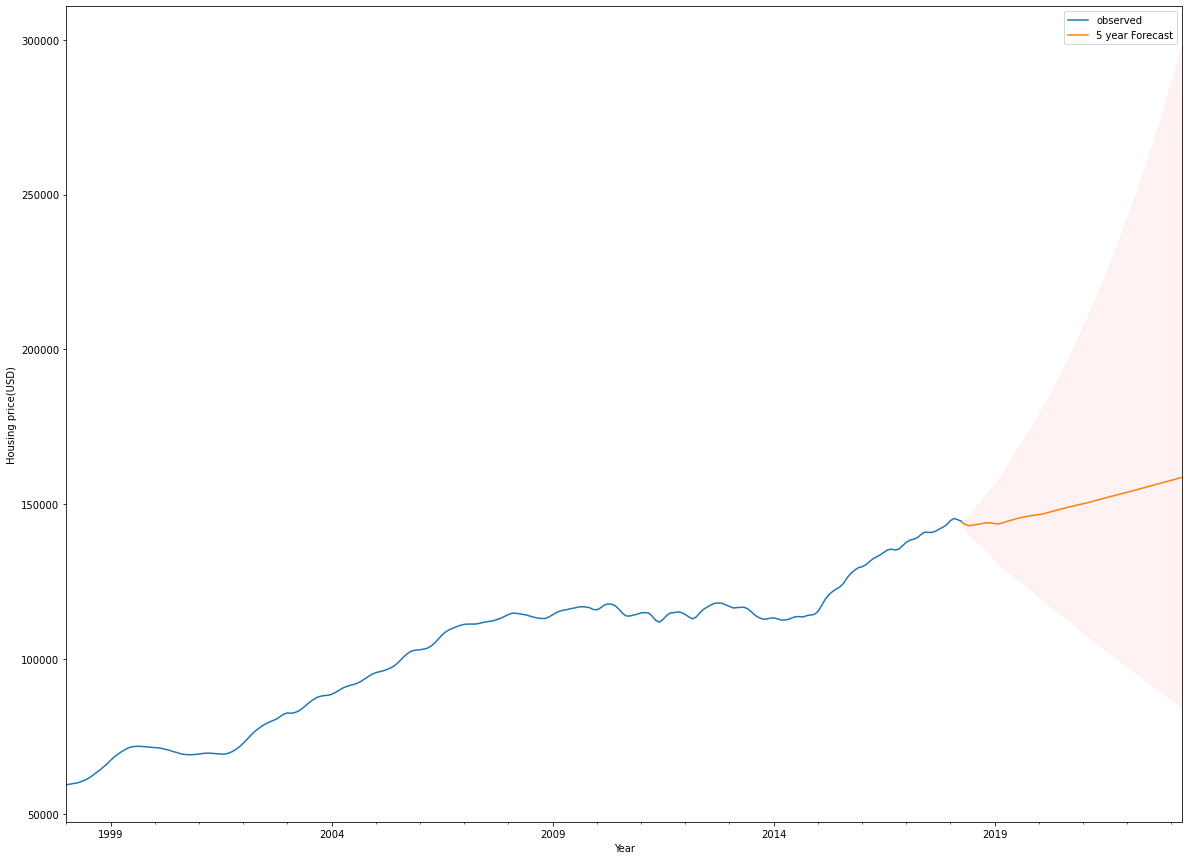

Expected 5 year return (USD):[158725.69120226]
Expected 5 year return (percent):[9.844769]
Results for zipcode : 70810
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5661      0.039     14.332      0.000       0.489       0.644
ma.S.L12      -0.3067      0.064     -4.804      0.000      -0.432      -0.182
sigma2      2.218e-06   1.84e-07     12.084      0.000    1.86e-06    2.58e-06


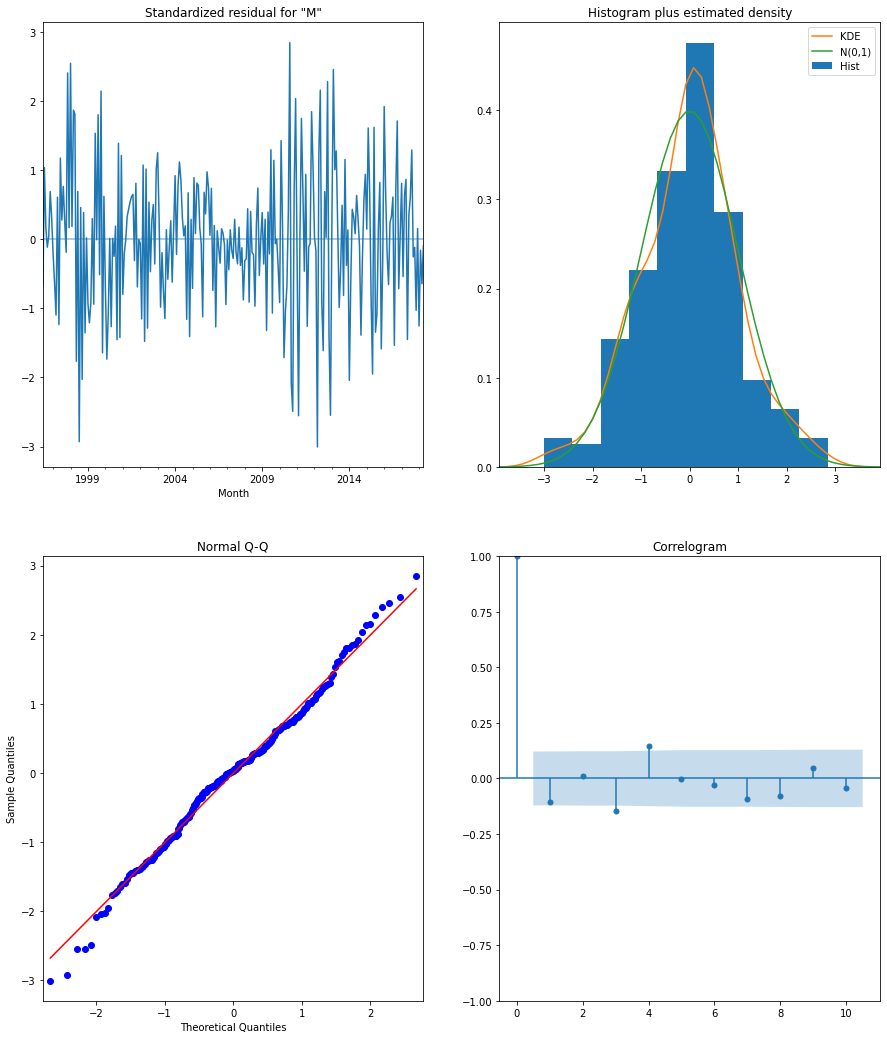

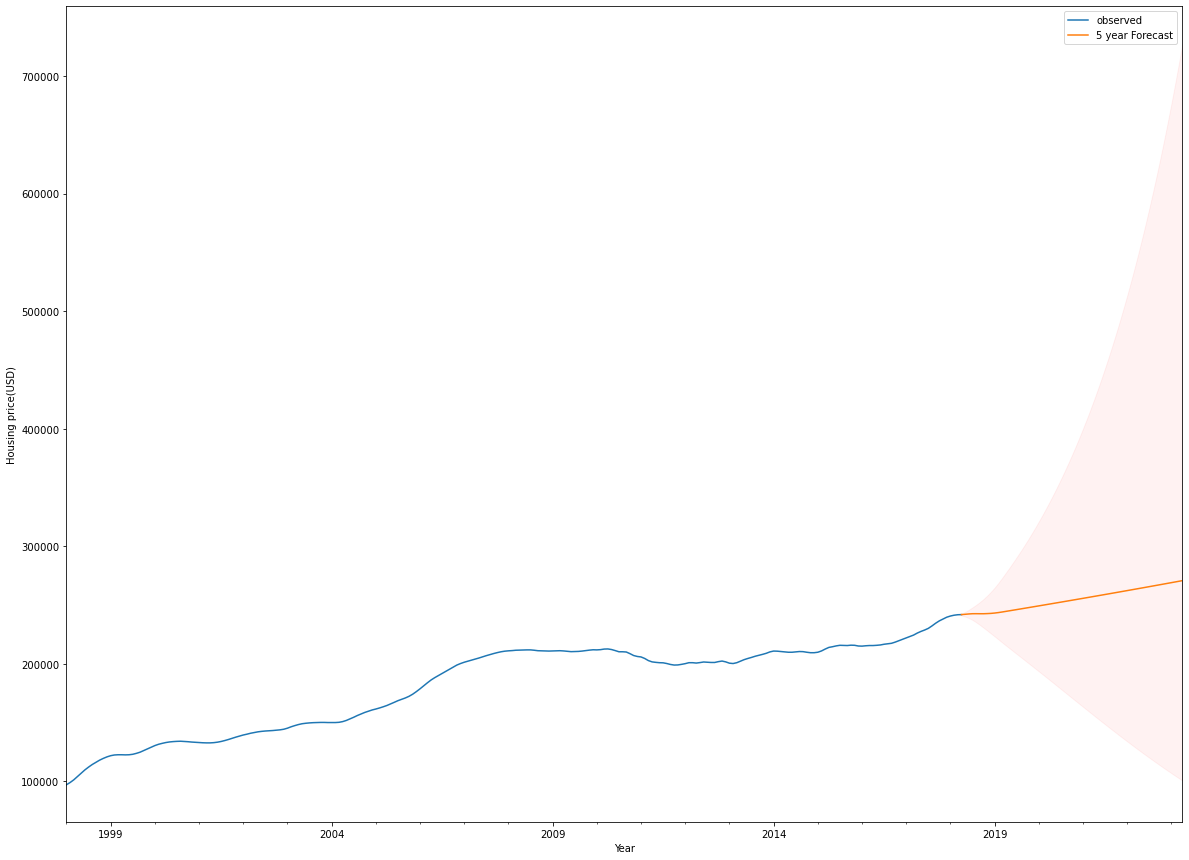

Expected 5 year return (USD):[270812.8987583]
Expected 5 year return (percent):[11.95241784]
Results for zipcode : 78744
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3097      0.035      8.728      0.000       0.240       0.379
ar.L2         -0.3971      0.039    -10.087      0.000      -0.474      -0.320
ma.S.L12      -0.2487      0.050     -4.952      0.000      -0.347      -0.150
ma.S.L24      -0.2455      0.062     -3.956      0.000      -0.367      -0.124
sigma2      7.699e-06   5.66e-07     13.598      0.000    6.59e-06    8.81e-06


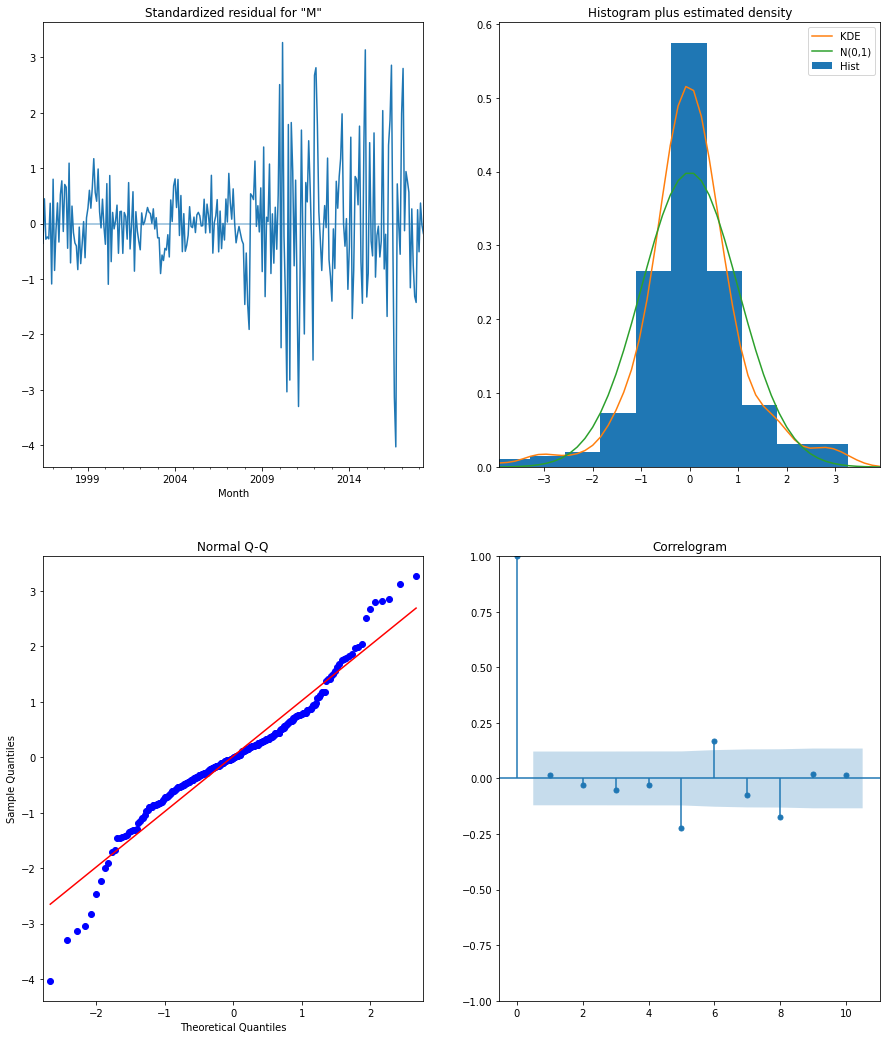

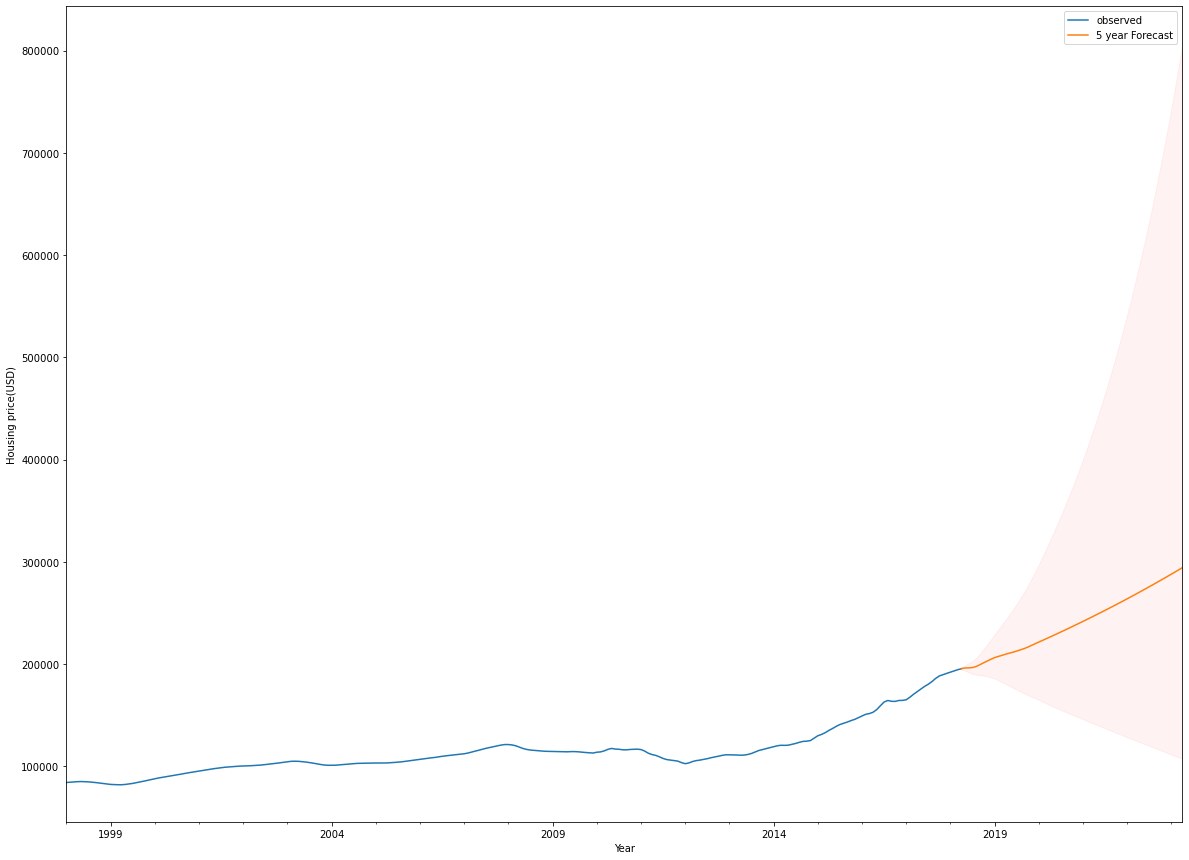

Expected 5 year return (USD):[294349.83170592]
Expected 5 year return (percent):[50.56257376]
Results for zipcode : 68516
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1072      0.101     10.942      0.000       0.909       1.305
ar.L2         -0.2455      0.102     -2.418      0.016      -0.444      -0.046
ma.L1          0.4378      0.085      5.163      0.000       0.272       0.604
ar.S.L12       0.5284      1.024      0.516      0.606      -1.479       2.536
ma.S.L12      -0.5678      0.993     -0.572      0.567      -2.513       1.378
sigma2      2.702e-06   2.04e-07     13.265      0.000     2.3e-06     3.1e-06


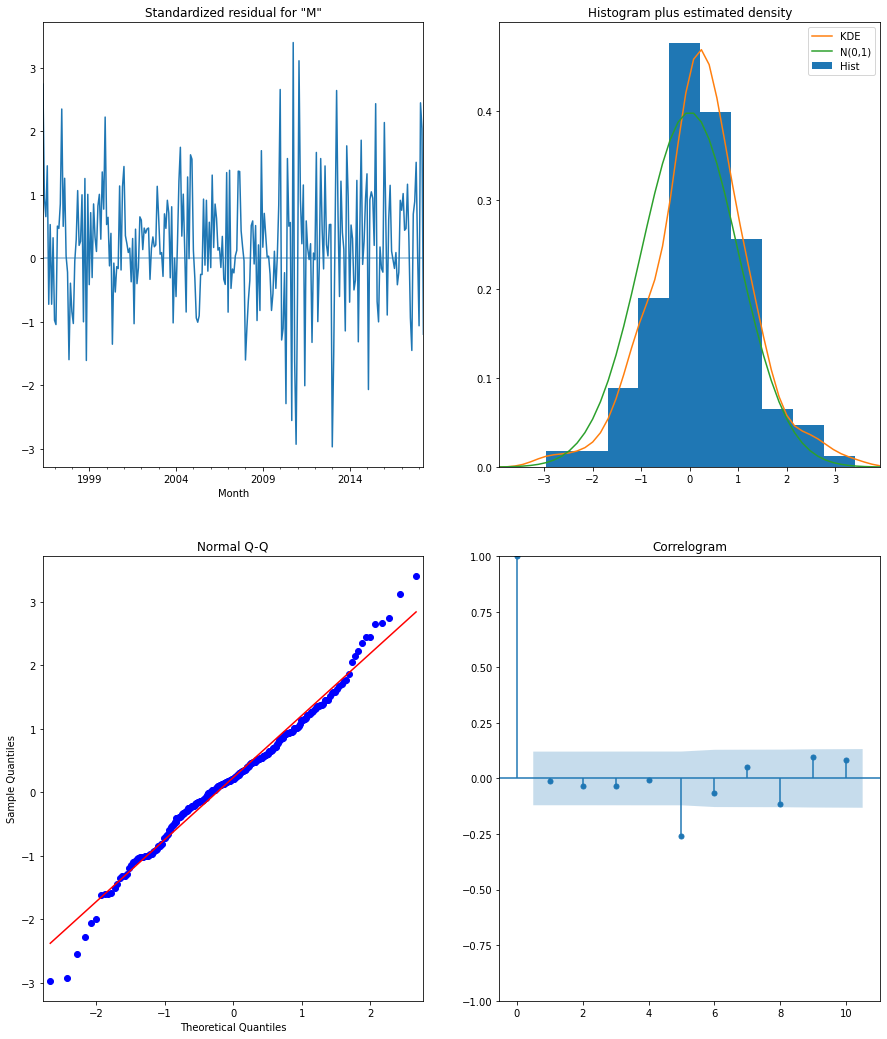

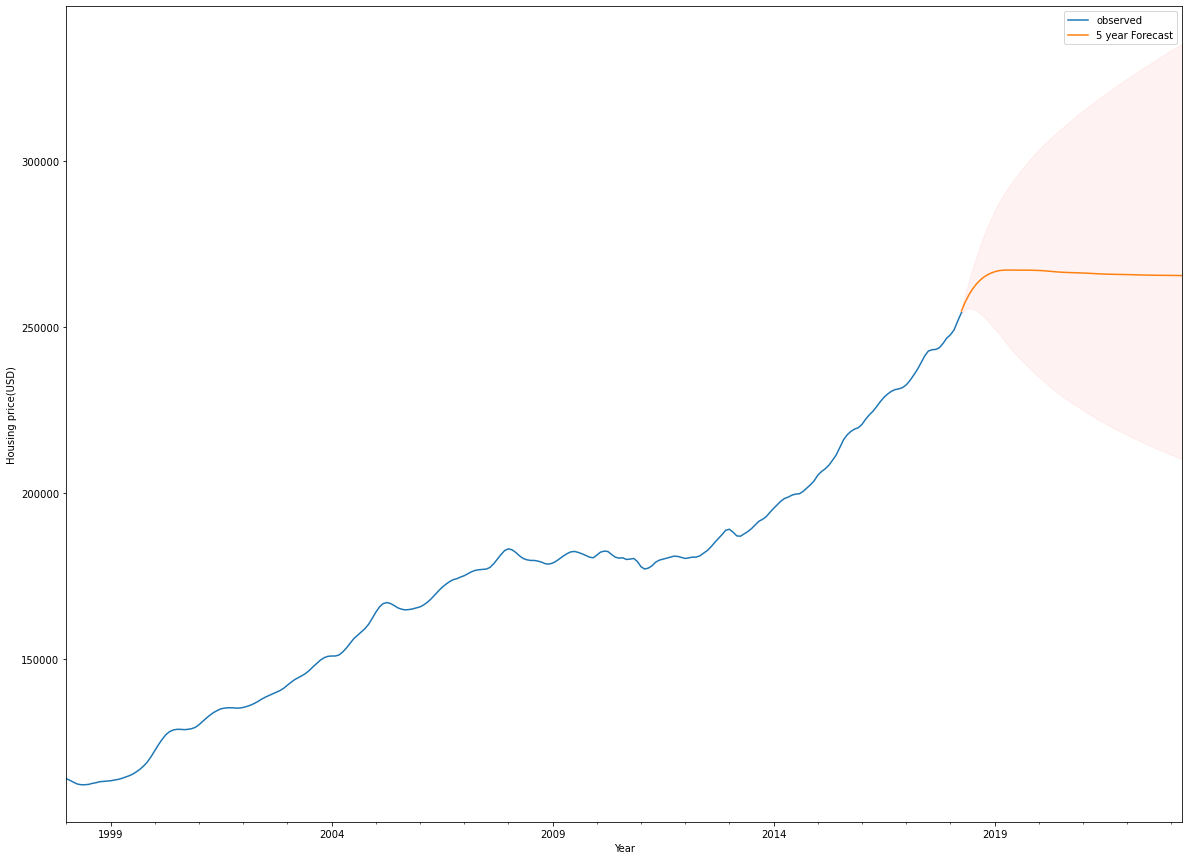

Expected 5 year return (USD):[265554.10458667]
Expected 5 year return (percent):[4.38447507]
Results for zipcode : 27609
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9076      0.022     41.302      0.000       0.865       0.951
ma.L1          0.5347      0.047     11.324      0.000       0.442       0.627
ma.S.L12      -0.0806      0.059     -1.372      0.170      -0.196       0.035
ma.S.L24      -0.2872      0.051     -5.668      0.000      -0.386      -0.188
sigma2      1.961e-06    1.6e-07     12.249      0.000    1.65e-06    2.28e-06


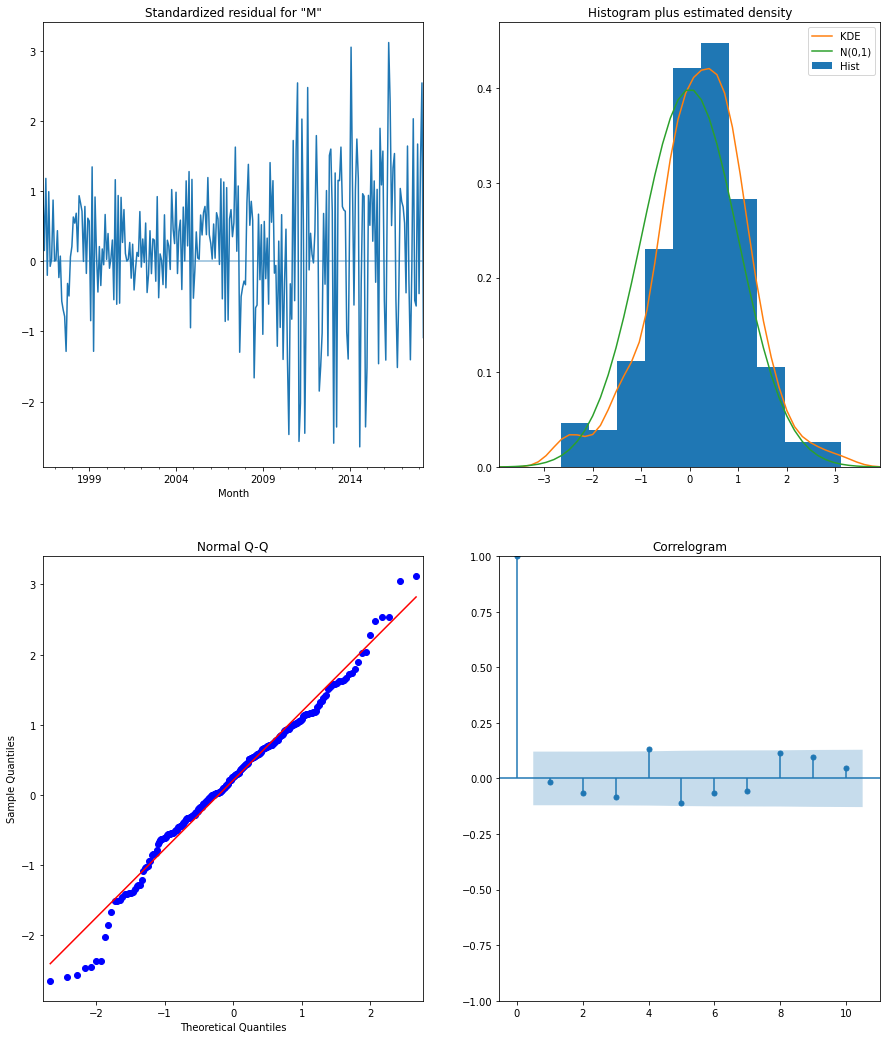

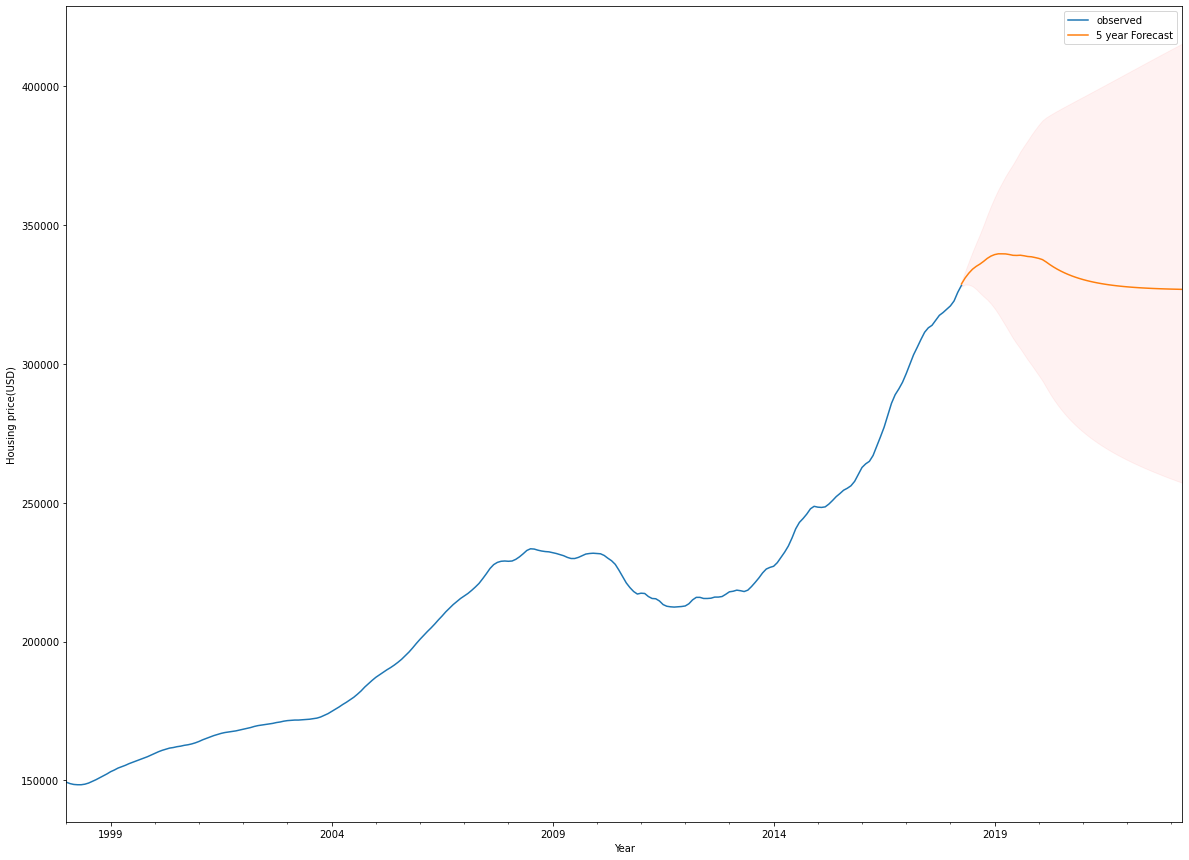

Expected 5 year return (USD):[326855.56119134]
Expected 5 year return (percent):[-0.43997527]
Results for zipcode : 78753
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3846      0.041      9.284      0.000       0.303       0.466
ma.S.L12      -0.2160      0.050     -4.282      0.000      -0.315      -0.117
sigma2      3.981e-06   2.76e-07     14.416      0.000    3.44e-06    4.52e-06


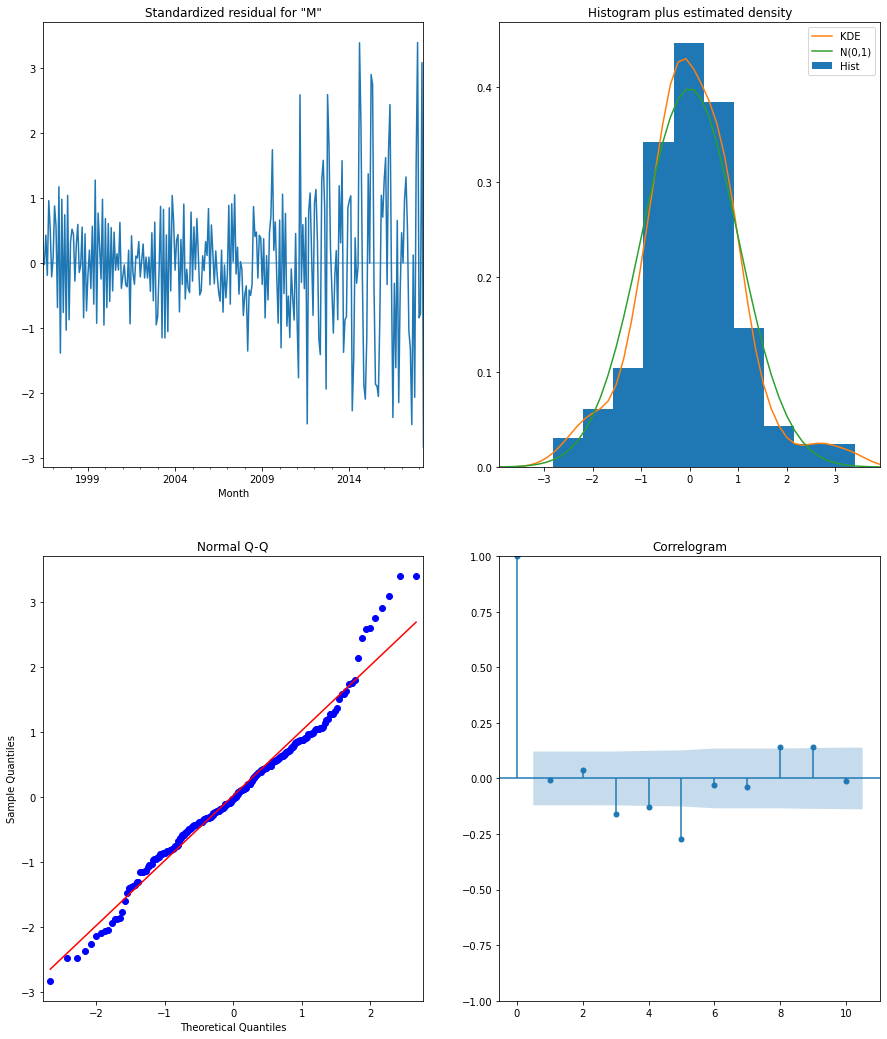

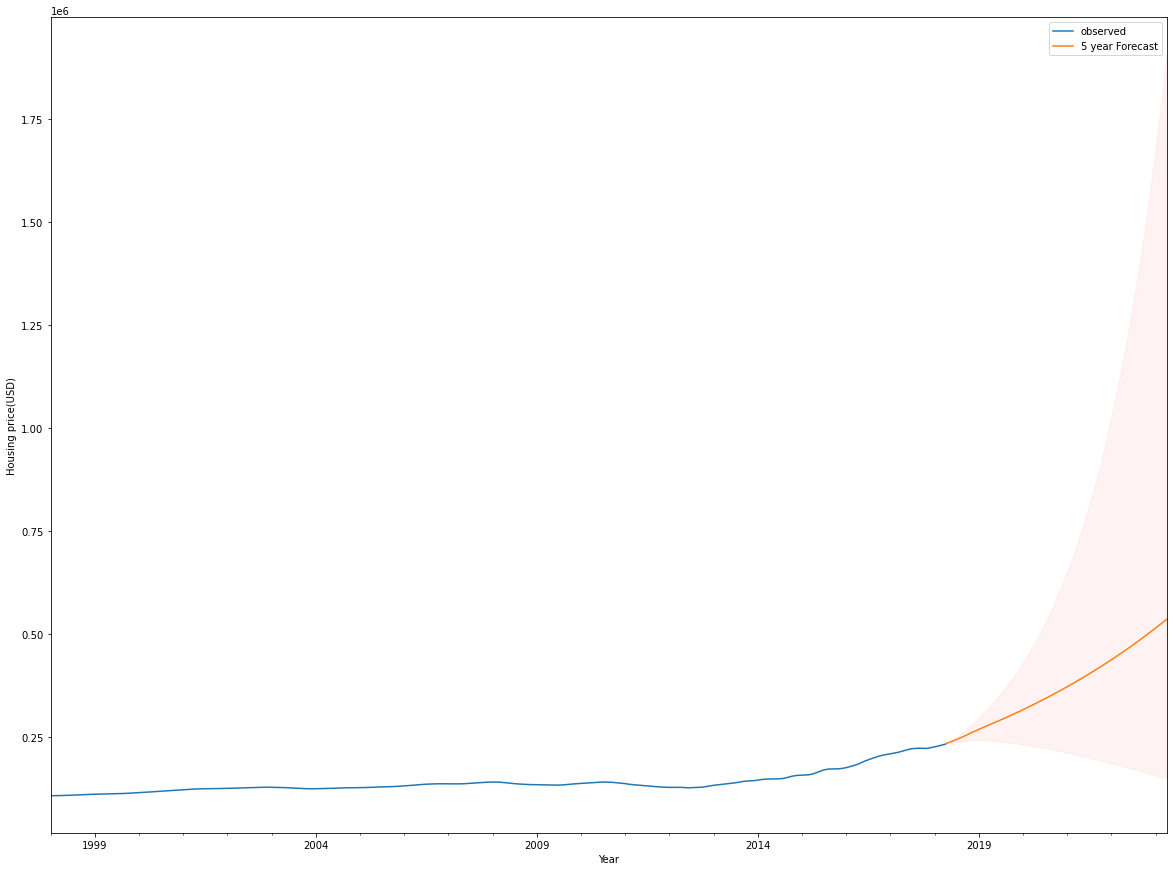

Expected 5 year return (USD):[536139.22436999]
Expected 5 year return (percent):[129.70832235]
Results for zipcode : 84118
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9042      0.022     41.403      0.000       0.861       0.947
ma.L1          0.6693      0.042     15.907      0.000       0.587       0.752
ma.S.L12      -0.0046      0.037     -0.125      0.900      -0.076       0.067
ma.S.L24      -0.4763      0.047    -10.123      0.000      -0.569      -0.384
sigma2      5.096e-06   3.35e-07     15.222      0.000    4.44e-06    5.75e-06


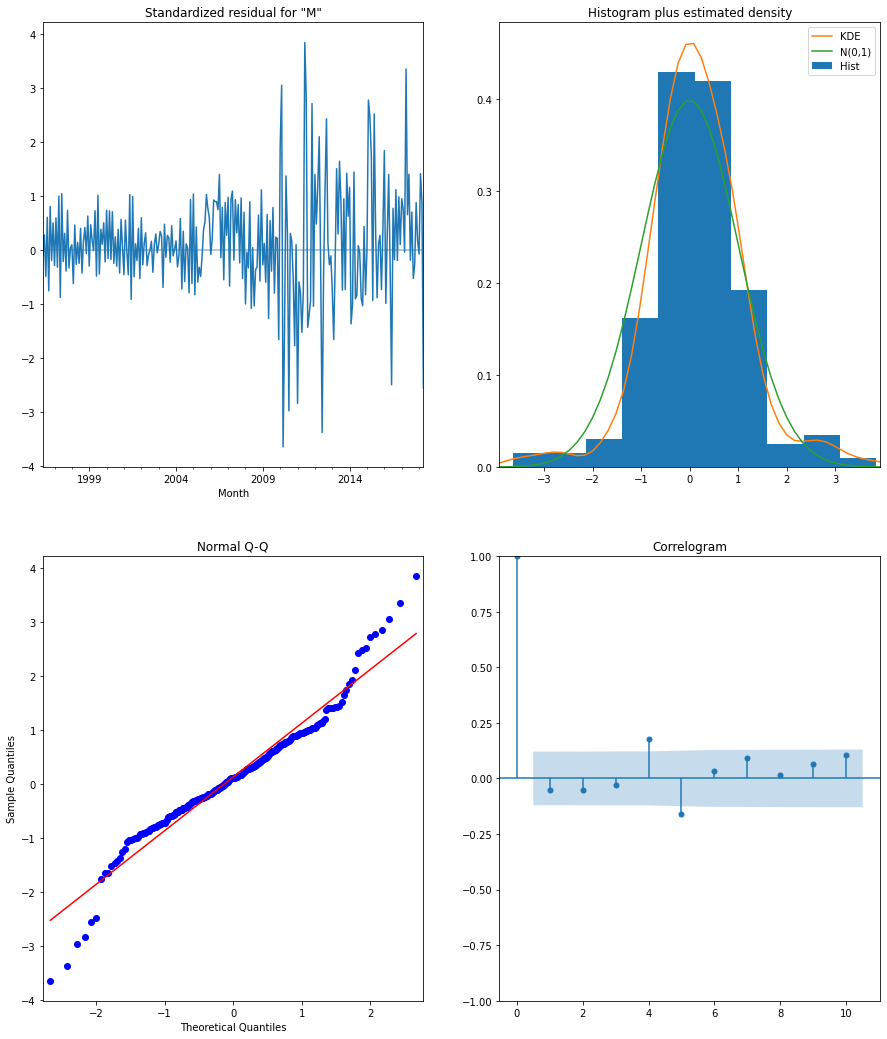

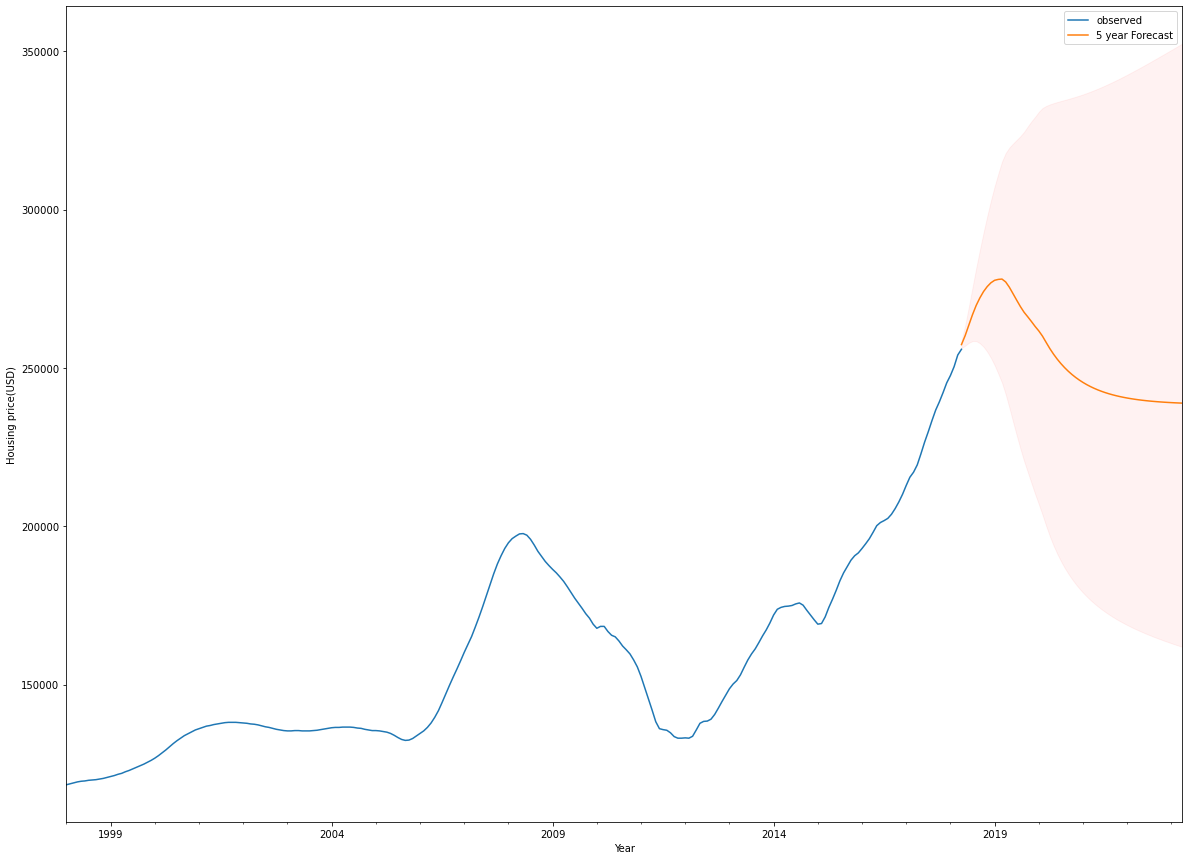

Expected 5 year return (USD):[238892.71029255]
Expected 5 year return (percent):[-6.64606866]


In [107]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams

#Fit the SARIMA model and get results.
for i in range(len(data_diff)):
    ARIMA_MODEL  =SARIMAX(df_log[i],seasonal_order=ARIMA_results[i].seasonal_order,order=ARIMA_results[i].order)
    output = ARIMA_MODEL.fit()
    print (f'Results for zipcode : {df_zip[i].Zipcode[i]}')
    print(output.summary().tables[1])
    output.plot_diagnostics(figsize=(15, 18))
    plt.show()
    
    # Plot observed values
    ax=np.exp(df_log[i]['1998':]).plot(label='observed', figsize=(20, 15))
    pred = output.get_prediction(start='2018-04',end='2023-04',full_results = True,dynamic=True)
    pred_conf = pred.conf_int()
    rcParams['figure.figsize'] = 15, 6

    # Plot predicted values
    pred.predicted_mean=np.exp(pred.predicted_mean)
    pred.predicted_mean.plot( ax=ax, label='5 year Forecast')
    # Plot the range for confidence intervals
    pred_conf = np.exp(pred_conf)
    ax.fill_between(pred_conf.index,
    pred_conf.iloc[:, 0],
    pred_conf.iloc[:, 1], color='r',alpha=0.05)
    ax.set_xlabel('Year')
    ax.set_ylabel('Housing price(USD)')
    plt.legend()

    plt.show()
    new=pred.predicted_mean[-1:].values
    original=np.exp(df_log[i][-1:].values)
    temp=((new-original)*100/original)
    print(f'Expected 5 year return (USD):{pred.predicted_mean[-1:].values}')
    print(f'Expected 5 year return (percent):{temp}')
    df_result.loc[df_zip[i].Zipcode[i], '5_yr_return'] = temp





### Results

In [108]:
df_result

,5_yr_return
Zipcode,
80525,-0.137402
70806,25.931204
70808,48.125587
73069,9.844769
70810,11.952418
78744,50.562574
68516,4.384475
27609,-0.439975
78753,129.708322


Based on 3-5% yearly appreciation we can expect 15-28% overall return in 5 years . Based on the results above the 5 best zipcodes  are 70806,70808,73069,70810,78753. The reason I selected these 5 zipcodes is because they have 
1)The residuals show some changing variation over time but they are relatively stationary,This heteroscedasticity will potentially make the prediction interval slightly inaccurate.
2)Residuals are more or less normally distributed.
3)Although there exists some autocorrelation, it is not particularly large and it is unlikely to have any noticeable impact on the forecasts or the prediction intervals.

Going over zipcodes that werent selected :
1)80525,68516,27609
For 80525,68516 the distribution satisfies all assumptions for regression although the forecast is projecting a negative or a low return 
2)78744
For 78744 although is forecasting high returns(50%) the qq plot suggests that the residuals are not normaly distributed and hence the forecasting might not be very accurate. 
3)84118
For 84118 the forecast is negative and the residuals are not normally distributed.

### Future work:  
1)Out of nearly 15k zipcodes the 3 i have come to chose are from Baton rouge LA which suggests that some external factors did not affect the housing market in these regions compared to others  during the recession and they continute to appreciate over 5% per year.So I wanted to see if certain zipcodes can be clustered together based on the underlying geography as an external factor.
2) Also the model preiction can be improved by including other external factors such as mortgage rates, local economy, income , crime etc
3) I would like to also inlcude and analyze rental data as rental income can be a factor in real estate investment.